In [ ]:
%cd ./../

In [34]:
import torch
import os
import random 
import pickle
import scipy

import networkx as nx
import numpy as np

from subgraph.utils import cudavar
from sklearn.metrics import average_precision_score
from subgraph.earlystopping import EarlyStoppingModule
from GMN.configure import get_default_config

In [3]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

av = Namespace(   want_cuda                    = True,
                  has_cuda                   = torch.cuda.is_available(),
                  use_pairnorm               = False,
                  is_sig                     = False,
                  n_layers                   = 3,
                  conv_type                  = 'SAGE',
                  method_type                = 'order',
                  skip                       = 'learnable',
                  MIN_QUERY_SUBGRAPH_SIZE    = 5,
                  MAX_QUERY_SUBGRAPH_SIZE    = 10,
                  MIN_CORPUS_SUBGRAPH_SIZE   = 11,
                  MAX_CORPUS_SUBGRAPH_SIZE   = 15,
                  DIR_PATH                   =".",
                  DATASET_NAME               = "ptc_fr",
                  RUN_TILL_ES                = True,
                  ES                         = 50,
                  transform_dim              = 16,
                  GMN_NPROPLAYERS            = 5,
                  FEAT_TYPE                  = "One",
                  filters_1                  = 10,
                  filters_2                  = 10,
                  filters_3                  = 10,
                  neuromatch_hidden_dim      = 10,
                  post_mp_dim                = 64,
                  bottle_neck_neurons        = 10,
                  tensor_neurons             = 10,               
                  dropout                    = 0,
                  bins                       = 16,
                  histogram                  = False,
                  WEIGHT_DECAY               =5*10**-4,
                  BATCH_SIZE                 =128,
                  LEARNING_RATE              =0.001,
                  CONV                       = "GCN",
                  MARGIN                     = 0.1,
                  NOISE_FACTOR               = 0,
                  NUM_RUNS                   = 2,
                  TASK                       = "",
                  test_size                  = 25,
              )

In [4]:
def load_config(): 
  config = get_default_config()

  config['encoder'] ['node_hidden_sizes'] = [10]
  config['encoder'] ['node_feature_dim'] = 1
  config['encoder'] ['edge_feature_dim'] = 1
    
  config['aggregator'] ['node_hidden_sizes'] = [10]
  config['aggregator'] ['graph_transform_sizes'] = [10]
  config['aggregator'] ['input_size'] = [10]

  config['graph_matching_net'] ['node_state_dim'] = 10
  config['graph_matching_net'] ['n_prop_layers'] = av.GMN_NPROPLAYERS
  config['graph_matching_net'] ['edge_hidden_sizes'] = [20]
  config['graph_matching_net'] ['node_hidden_sizes'] = [10]
    
  config['graph_embedding_net'] ['node_state_dim'] = 10
  config['graph_embedding_net'] ['n_prop_layers'] = av.GMN_NPROPLAYERS
  config['graph_embedding_net'] ['edge_hidden_sizes'] = [20]
  config['graph_embedding_net'] ['node_hidden_sizes'] = [10]
  
  config['graphsim']= {}
  config['graphsim']['conv_kernel_size'] = [10,4,2]
  config['graphsim']['linear_size'] = [24, 16]
  config['graphsim']['gcn_size'] = [10,10,10]
  config['graphsim']['conv_pool_size'] = [3,3,2]
  config['graphsim']['conv_out_channels'] = [2,4,8]
  config['graphsim']['dropout'] = av.dropout

  config['training']['batch_size']  = av.BATCH_SIZE
  config['training']['margin']  = av.MARGIN
  config['evaluation']['batch_size']  = av.BATCH_SIZE
  config['model_type']  = "embedding"

  seed = config['seed']
  random.seed(seed)
  np.random.seed(seed + 1)
  torch.manual_seed(seed + 2)
  torch.backends.cudnn.deterministic = False
    
  return config

In [5]:
import os
import subgraph.iso_matching_models as im

es = EarlyStoppingModule(av,50)
device = "cuda" if av.has_cuda and av.want_cuda else "cpu"

Using backend: pytorch


In [6]:
def fetch_per_qnode_ap(av,model,sampler):
  model.eval()
  d_pos = sampler.list_pos
  d_neg = sampler.list_neg
  d = d_pos + d_neg
  npos = len(d_pos)
  nneg = len(d_neg) 

  q_graphs = list(range(len(sampler.query_graphs)))    
    
  all_ap = []

  for q_id in q_graphs:
    dpos = list(filter(lambda x:x[0][0]==q_id,d_pos))
    dneg = list(filter(lambda x:x[0][0]==q_id,d_neg))
    npos = len(dpos)
    nneg = len(dneg)
    d = dpos+dneg
    if npos>0 and nneg>0:    
      #Damn
      n_batches = sampler.create_batches(d) 
      pred = []  
      for i in range(n_batches):
        #ignoring known ged values here since not needed for AP ranking score 
        batch_data,batch_data_sizes,_,batch_adj = sampler.fetch_batched_data_by_id(i)
        pred.append( model(batch_data,batch_data_sizes,batch_adj).data)
      all_pred = torch.cat(pred,dim=0) 
      labels = cudavar(av,torch.cat((torch.ones(npos),torch.zeros(nneg))))
      ap   = average_precision_score(labels.cpu(), all_pred.cpu()) 
      all_ap.append(ap)  
  return all_ap

def fetch_gmn_data():
    data_mode = "test" if av.test_size==25 else "Extra_test_300"
    test_data = im.OurMatchingModelSubgraphIsoData(av,mode=data_mode)
    val_data = im.OurMatchingModelSubgraphIsoData(av,mode="val")
    test_data.data_type = "gmn"
    val_data.data_type = "gmn"
    return val_data, test_data


def get_result(task,dataset,mode=""):
    #config = load_config()
    av.TASK = task
    av.DATASET_NAME = dataset 

    if av.FEAT_TYPE == "Adjrow" or  av.FEAT_TYPE == "Adjrow1" or av.FEAT_TYPE == "AdjOnehot": 
      av.TASK = av.TASK + "_" + av.FEAT_TYPE

    val_data, test_data = fetch_gmn_data()
    if av.TASK.startswith("matching_iso_var_18_gmn_sinkhorn_param_big_hinge_score_on_embeds"):
      config = load_config()
      model = im.Node_align_Node_loss(av,config,1).to(device)
      test_data.data_type = "gmn"
      val_data.data_type = "gmn"
    elif av.TASK.startswith("matching_iso_var_19_gmn_all"):
      config = load_config()
      model = im.GMN_embed(av,config,1).to(device)
      test_data.data_type = "gmn"
      val_data.data_type = "gmn"
    elif av.TASK.startswith("matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges"):
      #One more hack. 
      av.MAX_EDGES = max(max([g.number_of_edges() for g in test_data.query_graphs]),\
                   max([g.number_of_edges() for g in test_data.corpus_graphs]))
      config = load_config()
      model = im.ISONET(av,config,1).to(device)
      test_data.data_type = "gmn"
      val_data.data_type = "gmn"
    elif av.TASK.startswith("matching_iso_var_29_gmn_sinkhorn_param_big_hinge_score_on_edge_similarity_ff_adj_mask"):
      config = load_config()
      model = im.Node_align_Edge_loss(av,config,1).to(device)
      test_data.data_type = "gmn"
      val_data.data_type = "gmn"
    elif av.TASK.startswith("matching_iso_var_34_gmn_embed_hinge"):
      config = load_config()
      model = im.GMN_embed_hinge(av,config,1).to(device)
      test_data.data_type = "gmn"
      val_data.data_type = "gmn"
    elif av.TASK.startswith("matching_iso_var_35_gmn_match_hinge"):
      config = load_config()
      model = im.GMN_match_hinge(av,config,1).to(device)
      test_data.data_type = "gmn"
      val_data.data_type = "gmn"
    elif av.TASK.startswith("matching_iso_var_36_gmn_edge_perm_sinkhorn_param_big_sqeuc_score_on_edges"):
      av.MAX_EDGES = max(max([g.number_of_edges() for g in test_data.query_graphs]),\
                     max([g.number_of_edges() for g in test_data.corpus_graphs]))
      config = load_config()
      model = im.ISONET_Sym(av,config,1).to(device)
      test_data.data_type = "gmn"
      val_data.data_type = "gmn"
    elif av.TASK.startswith("simgnn_noperm") :
      config = load_config()
      model = im.SimGNN(av,1).to(device)
      test_data.data_type = "pyg"
      val_data.data_type = "pyg"    
    elif av.TASK.startswith("gmn_match"):
      config = load_config()
      model = im.GMN_match(av,config,1).to(device)
      test_data.data_type = "gmn"
      val_data.data_type = "gmn"
    elif av.TASK.startswith("matching_iso_graphsim"):
      config = load_config()
      model = im.GraphSim(av,config,1).to(device)
      test_data.data_type = "pyg"
      val_data.data_type = "pyg"
    elif av.TASK.startswith("matching_iso_neuromatch"):
      config = load_config()
      model = im.NeuroMatch(1,av.neuromatch_hidden_dim,av).to(device)
      test_data.data_type = "pyg"
      val_data.data_type = "pyg"
    elif av.TASK.startswith("ir_modified_gotsim"):
      config = load_config()
      model = im.GOTSim(av,config,1).to(device)
      test_data.data_type = "pyg"
      val_data.data_type = "pyg"
    else:
      print("ALERT!! CHECK FOR ERROR")  
    model.eval()
    checkpoint = es.load_best_model()
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if mode=="fetch_perqnode_ap":
        return fetch_per_qnode_ap(av,model,test_data)
    
    val_result = evaluate_embeddings_similarity_map_mrr_mndcg(av,model,val_data)
    test_result = evaluate_embeddings_similarity_map_mrr_mndcg(av,model,test_data)

    return val_result, test_result

In [7]:
task_dict = {} 

task_dict['Node-align(Node loss)'] = {}
task_dict['Node-align(Node loss)']["ptc_fm"] = "matching_iso_var_18_gmn_sinkhorn_param_big_hinge_score_on_embeds_run7_corrected_noise0_margin2E-1"
task_dict['Node-align(Node loss)']["ptc_fr"] = "matching_iso_var_18_gmn_sinkhorn_param_big_hinge_score_on_embeds_run7_corrected_noise0_margin2E-1"
task_dict['Node-align(Node loss)']["ptc_mr"] = "matching_iso_var_18_gmn_sinkhorn_param_big_hinge_score_on_embeds_run1_corrected_noise0_margin2E-1"
task_dict['Node-align(Node loss)']["ptc_mm"] = "matching_iso_var_18_gmn_sinkhorn_param_big_hinge_score_on_embeds_run1_corrected_noise0_margin2E-1"
task_dict['Node-align(Node loss)']["mutag"]  = "matching_iso_var_18_gmn_sinkhorn_param_big_hinge_score_on_embeds_run1_corrected_noise0_margin2E-1"
task_dict['Node-align(Node loss)']["aids"]   = "matching_iso_var_18_gmn_sinkhorn_param_big_hinge_score_on_embeds_run1_corrected_noise0_margin2E-1"

task_dict['GMN-embed'] = {}
task_dict['GMN-embed']["ptc_fm"] = "matching_iso_var_19_gmn_all_run3_margin2E-1_corrected"
task_dict['GMN-embed']["ptc_fr"] = "matching_iso_var_19_gmn_all_run3_margin2E-1_corrected"
task_dict['GMN-embed']["ptc_mr"] = "matching_iso_var_19_gmn_all_run1_margin2E-1_corrected"
task_dict['GMN-embed']["ptc_mm"] = "matching_iso_var_19_gmn_all_run1_margin2E-1_corrected"
task_dict['GMN-embed']["mutag"]  = "matching_iso_var_19_gmn_all_run1_margin2E-1_corrected"
task_dict['GMN-embed']["aids"]   = "matching_iso_var_19_gmn_all_run1_margin2E-1_corrected"


task_dict['ISONET'] = {}
task_dict['ISONET']["ptc_fm"] = "matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1"
task_dict['ISONET']["ptc_fr"] = "matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1"
task_dict['ISONET']["ptc_mr"] = "matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1"
task_dict['ISONET']["ptc_mm"] = "matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1"
task_dict['ISONET']["mutag"]  = "matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1"
task_dict['ISONET']["aids"]   = "matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1"

task_dict['Node-align(Edge loss)'] = {}
task_dict['Node-align(Edge loss)']["ptc_fm"] = "matching_iso_var_29_gmn_sinkhorn_param_big_hinge_score_on_edge_similarity_ff_adj_mask_run1_corrected_noise0_margin2E-1"
task_dict['Node-align(Edge loss)']["ptc_fr"] = "matching_iso_var_29_gmn_sinkhorn_param_big_hinge_score_on_edge_similarity_ff_adj_mask_run1_corrected_noise0_margin2E-1"
task_dict['Node-align(Edge loss)']["ptc_mr"] = "matching_iso_var_29_gmn_sinkhorn_param_big_hinge_score_on_edge_similarity_ff_adj_mask_run1_corrected_noise0_margin2E-1"
task_dict['Node-align(Edge loss)']["ptc_mm"] = "matching_iso_var_29_gmn_sinkhorn_param_big_hinge_score_on_edge_similarity_ff_adj_mask_run1_corrected_noise0_margin2E-1"
task_dict['Node-align(Edge loss)']["mutag"]  = "matching_iso_var_29_gmn_sinkhorn_param_big_hinge_score_on_edge_similarity_ff_adj_mask_run1_corrected_noise0_margin2E-1"
task_dict['Node-align(Edge loss)']["aids"]   = "matching_iso_var_29_gmn_sinkhorn_param_big_hinge_score_on_edge_similarity_ff_adj_mask_run1_corrected_noise0_margin2E-1"

task_dict['GraphSim'] = {}
task_dict['GraphSim']["ptc_fm"] = "matching_iso_graphsim_score_logits_pair_loss_NoInterpolation_NoBfs_One_dropout0_margin5E-1_run1_corrected_noise0_margin5E-1"
task_dict['GraphSim']["ptc_fr"] = "matching_iso_graphsim_score_logits_pair_loss_NoInterpolation_NoBfs_One_dropout0_margin5E-1_run1_corrected_noise0_margin5E-1"
task_dict['GraphSim']["ptc_mr"] = "matching_iso_graphsim_score_logits_pair_loss_NoInterpolation_NoBfs_One_dropout0_margin5E-1_run1_corrected_noise0_margin5E-1"
task_dict['GraphSim']["ptc_mm"] = "matching_iso_graphsim_score_logits_pair_loss_NoInterpolation_NoBfs_One_dropout0_margin5E-1_run1_corrected_noise0_margin5E-1"
task_dict['GraphSim']["mutag"]  = "matching_iso_graphsim_score_logits_pair_loss_NoInterpolation_NoBfs_One_dropout0_margin5E-1_run1_corrected_noise0_margin5E-1"
task_dict['GraphSim']["aids"]   = "matching_iso_graphsim_score_logits_pair_loss_NoInterpolation_NoBfs_One_dropout0_margin5E-1_run1_corrected_noise0_margin5E-1"

    
task_dict['GOTSim'] = {}
for dataset in ['ptc_fr','ptc_fm','ptc_mr','ptc_mm','mutag','aids' ]:
  task_dict['GOTSim'][dataset] = "ir_modified_gotsim_run1"


task_dict['GMN-embed-Asym'] = {}
task_dict['GMN-match-Asym'] = {}
task_dict['ISONET-Sym'] = {}
for dataset in ['ptc_fr','ptc_fm','ptc_mr','ptc_mm','mutag','aids' ]:
  task_dict['GMN-embed-Asym'][dataset] = "matching_iso_var_34_gmn_embed_hinge_run1_margin2E-1"
  if dataset == "ptc_fm":
    task_dict['GMN-match-Asym'][dataset] = "matching_iso_var_35_gmn_match_hinge_run2_margin2E-1"
  else:
    task_dict['GMN-match-Asym'][dataset] = "matching_iso_var_35_gmn_match_hinge_run1_margin2E-1"
  task_dict['ISONET-Sym'][dataset] = "matching_iso_var_36_gmn_edge_perm_sinkhorn_param_big_sqeuc_score_on_edges_run1_corrected_noise0_margin2E-1"


task_dict['NeuroMatch'] = {}
task_dict['NeuroMatch']["ptc_fm"] = "matching_iso_neuromatch_hid_dim10_post_mp64_dropout0_margin5E-1_run1_corrected_noise0_margin5E-1"
task_dict['NeuroMatch']["ptc_fr"] = "matching_iso_neuromatch_hid_dim10_post_mp64_dropout0_margin5E-1_run1_corrected_noise0_margin5E-1"
task_dict['NeuroMatch']["ptc_mr"] = "matching_iso_neuromatch_hid_dim10_post_mp64_dropout0_margin5E-1_run1_corrected_noise0_margin5E-1"
task_dict['NeuroMatch']["ptc_mm"] = "matching_iso_neuromatch_hid_dim10_post_mp64_dropout0_margin5E-1_run1_corrected_noise0_margin5E-1"
task_dict['NeuroMatch']["mutag"]  = "matching_iso_neuromatch_hid_dim10_post_mp64_dropout0_margin5E-1_run1_corrected_noise0_margin5E-1"
task_dict['NeuroMatch']["aids"]   = "matching_iso_neuromatch_hid_dim10_post_mp64_dropout0_margin5E-1_run1_corrected_noise0_margin5E-1"


task_dict['SimGNN'] = {}
task_dict['SimGNN']["ptc_fm"] = "simgnn_noperm_run4_margin2E-1"
task_dict['SimGNN']["ptc_fr"] = "simgnn_noperm_run3_margin10E-1"
task_dict['SimGNN']["ptc_mr"] = "simgnn_noperm_run4_margin2E-1" 
task_dict['SimGNN']["ptc_mm"] = "simgnn_noperm_run4_margin2E-1" 
task_dict['SimGNN']["mutag"]  = "simgnn_noperm_run3_margin10E-1" 
task_dict['SimGNN']["aids"]   = "simgnn_noperm_run4_margin2E-1" 

task_dict['GMN-match'] = {}
task_dict['GMN-match']["ptc_fm"] = "gmn_match_run1_margin2E-1"
task_dict['GMN-match']["ptc_fr"] = "gmn_match_run1_margin2E-1"
task_dict['GMN-match']["ptc_mr"] = "gmn_match_run1_margin2E-1" 
task_dict['GMN-match']["ptc_mm"] = "gmn_match_run1_margin2E-1" 
task_dict['GMN-match']["mutag"]  = "gmn_match_run2_margin2E-1" 
task_dict['GMN-match']["aids"]   = "gmn_match_run1_margin2E-1"


In [8]:
def fetch_best_model(task,dataset, test_data):
    config = load_config()
    av.TASK = task
    av.DATASET_NAME = dataset 
    av.FEAT_TYPE="One"
    if av.FEAT_TYPE == "Adjrow" or  av.FEAT_TYPE == "Adjrow1" or av.FEAT_TYPE == "AdjOnehot": 
      av.TASK = av.TASK + "_" + av.FEAT_TYPE

    if av.TASK.startswith("matching_iso_var_18_gmn_sinkhorn_param_big_hinge_score_on_embeds"): 
      model = im.Node_align_Node_loss(av,config,1).to(device)
    elif av.TASK.startswith("matching_iso_var_29_gmn_sinkhorn_param_big_hinge_score_on_edge_similarity_ff_adj_mask"):
      model = im.Node_align_Edge_loss(av,config,1).to(device)
    elif av.TASK.startswith("matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges"):
      #One more hack. 
      av.MAX_EDGES = max(max([g.number_of_edges() for g in test_data.query_graphs]),\
                   max([g.number_of_edges() for g in test_data.corpus_graphs]))
      model = im.ISONET(av,config,1).to(device)
    else:
      print("ALERT!! CHECK FOR ERROR")  
    model.eval()
    checkpoint = es.load_best_model()
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [9]:
def get_data(task, dataset):
    av.DATASET_NAME = dataset
    av.TASK = task
    data_mode = "test" if av.test_size==25 else "Extra_test_300"
    test_data = im.OurMatchingModelSubgraphIsoData(av,mode=data_mode)
    test_data.data_type = "gmn"
    bestM = fetch_best_model(task_dict[task][dataset],dataset, test_data)
    bestM.diagnostic_mode = False
    
    return im.eval_edge_alignment(av,bestM,test_data)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
sns.set()
sns.set_style("white")

# Hist Plot (Wait time: 2-3 min)

In [1]:
all_res = {}
av.test_size = 25
for task in ["ISONET"]:
    for dataset in ["ptc_fr","ptc_fm", "ptc_mr", "ptc_mm","mutag","aids"]:
        all_res[dataset] = get_data(task, dataset)

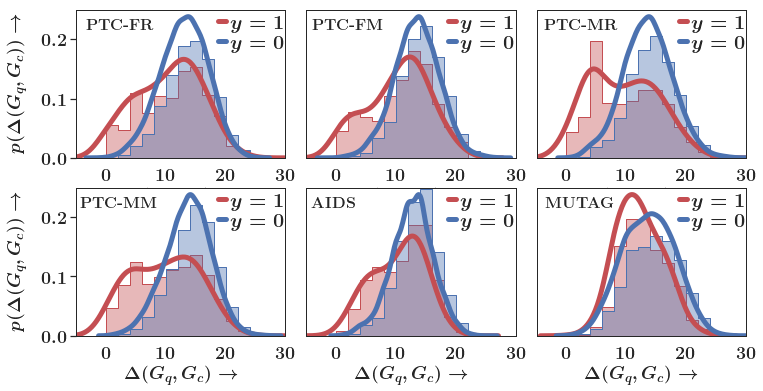

In [17]:
def plot_hist():
    
    import matplotlib
    %matplotlib inline
    from matplotlib import pyplot as plt
    import brewer2mpl
    bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
    color_list = bmap.mpl_colors
    color_list = [(0.4, 0.7607843137254902, 0.6470588235294118),
                 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
                 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
                 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
                 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
                 (1.0, 0.8509803921568627, 0.1843137254901961),
                 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
                 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

    color_list = [(1, 0, 0),
                 (0, 0, 1),
                  (0,0,0),
                 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
                 (0,0,0),
    #              (0.4, 0.7607843137254902, 0.6470588235294118),
                 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
                (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),]

    def latexify():
        matplotlib.rcParams['text.usetex'] = True
        matplotlib.rcParams['axes.spines.right'] = False
        matplotlib.rcParams['axes.spines.top'] = False
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
        plt.rc('axes', linewidth=1)
        plt.rc('font', weight='bold')
        matplotlib.rc('text', usetex=True)
        matplotlib.rcParams['text.latex.preamble']=r"\usepackage{bm} \usepackage{amsmath,amsfonts} \boldmath"

        
        

    #dataset="ptc_fm"

    latexify()
    fig, ((fr, fm, mr), (mm, aids, mutag)) = plt.subplots(2, 3, figsize=(12,6))
    plt.subplots_adjust(wspace=0.1)
    data_ids={}
    data_ids['ptc_fr'], data_ids['ptc_fm'] = fr, fm
    data_ids['ptc_mr'], data_ids['ptc_mm'] = mr, mm
    data_ids['aids'], data_ids['mutag'] = aids, mutag
    latex_dataset={'ptc_fr':r'\textbf{PTC-FR}', 'ptc_fm':r'\textbf{PTC-FM}', 'ptc_mr':r'\textbf{PTC-MR}', 'ptc_mm':r'\textbf{PTC-MM}', 'aids':r'\textbf{AIDS}', 'mutag':r'\textbf{MUTAG}'}
    
    i = 0
    for dataset in ["ptc_fr","ptc_fm", "ptc_mr", "ptc_mm","mutag","aids"]:
        
        all_ap1, all_ap3 , all_pos_hs1, all_neg_hs1, all_pos_hs3, all_neg_hs3 = all_res[dataset]
        binwidth=2
        sns.histplot(list(map(lambda x:-1*int(x),all_pos_hs1)), kde=False, stat="probability", color='r', element="step", label=latex_dataset[dataset],
             binwidth=binwidth, ax=data_ids[dataset], alpha=0.4)
        sns.histplot(list(map(lambda x:-1*int(x),all_neg_hs1)), kde=False, stat="probability", color='b', element="step",
             binwidth=binwidth, ax=data_ids[dataset], alpha=0.4)
        
        data_ids[dataset].set(ylabel=None)
        
        if i in [0,1,2,3,4,5]:
            data_ids[dataset].set_xlim([-5,30])
            data_ids[dataset].set_xticks([0, 10, 20, 30])
            data_ids[dataset].set_xlabel(r'\boldmath$\Delta(G_q,G_c)\rightarrow$', fontsize=18)
        else:
            data_ids[dataset].set_xlim([-5,30])
            data_ids[dataset].set_xticks([])
        
        if i in [0, 3]:
            data_ids[dataset].set_ylim([0,.25])
            data_ids[dataset].set_yticks([.0, .1, .2])
            data_ids[dataset].set_ylabel(r'\boldmath$p(\Delta(G_q,G_c))\rightarrow$', fontsize=18,labelpad=15)
        else:
            data_ids[dataset].set_ylim([0,.25])
            data_ids[dataset].set_yticks([])
            
        i += 1
        ax2 = data_ids[dataset].twinx()
        ax2.axes.yaxis.set_ticks([])

        data_ids[dataset].set_ylim([0,0.25])
        ax2 = data_ids[dataset].twinx()
        ax2.axes.yaxis.set_ticks([])

        sns.kdeplot(list(map(lambda x:-1*int(x),all_pos_hs1)), color="r", label="$y=1$", lw=5, bw_adjust=2, ax=ax2)
        sns.kdeplot(list(map(lambda x:-1*int(x),all_neg_hs1)), color="b", label="$y=0$", lw=5, bw_adjust=2, ax=ax2)
        ax2.legend(bbox_to_anchor=(0, 0, 1.08, 1.09), prop={'size': 20}, frameon=False, handlelength=0.4, labelspacing=0.1, handletextpad=0.2)
        
        if dataset=='aids':
            leg = data_ids[dataset].legend(bbox_to_anchor=(-0.78, -0.05, 1.08, 1.09),  prop={'size': 16}, frameon=False, handlelength=0, handletextpad=-0.2)
        elif dataset in ['ptc_mr', 'ptc_mm']:
            leg = data_ids[dataset].legend(bbox_to_anchor=(-0.62, -0.05, 1.08, 1.09),  prop={'size': 16}, frameon=False, handlelength=0, handletextpad=-0.2)
        else:
            leg = data_ids[dataset].legend(bbox_to_anchor=(-0.64, -0.05, 1.08, 1.09),  prop={'size': 16}, frameon=False, handlelength=0, handletextpad=-0.2)
        
        for item in leg.legendHandles:
            item.set_visible(False)

        plt.box(on=True)
        data_ids[dataset].spines['top'].set_visible(True)
        data_ids[dataset].spines['right'].set_visible(True)
    file = "interpretebility_histograms"+".pdf"
    plt.savefig(file, bbox_inches='tight') 
    plt.show()
plot_hist()

# Drill_down_plot (Wait time: 20min + without all_qnode_ap_dict pkl file)

In [2]:
all_qnode_ap_dict = {}
fp = av.DIR_PATH+"/Datasets/" +"all_qnode_ap_dict"+".pkl"
av.test_size = 300

if os.path.isfile(fp):
    with open(fp, 'rb') as f:
        all_qnode_ap_dict = pickle.load(f)

else:
    for task in ["ISONET","GMN-embed","GMN-match","NeuroMatch"]:   
        all_qnode_ap_dict[task] = {}
        for dataset in ["ptc_fm","ptc_fr","ptc_mm","ptc_mr","mutag","aids"]:
            all_qnode_ap_dict[task][dataset] = \
            get_result(task_dict[task][dataset],dataset,mode="fetch_perqnode_ap")
    with open(fp, 'wb') as f:
        pickle.dump(all_qnode_ap_dict, f)

In [14]:
score_dict = {}
for dataset in ["ptc_fm","ptc_fr","ptc_mm","ptc_mr","mutag","aids"]:
  score_dict[dataset] = {}
  score_dict[dataset]['x'] = list(range(len(all_qnode_ap_dict['ISONET'][dataset])))
  score_dict[dataset]['diff_gmnemb'] = sorted(list(np.array(all_qnode_ap_dict['ISONET'][dataset]) - np.array(all_qnode_ap_dict['GMN-embed'][dataset])))[::-1] 
  score_dict[dataset]['diff_gmnmat'] = sorted(list(np.array(all_qnode_ap_dict['ISONET'][dataset]) - np.array(all_qnode_ap_dict['GMN-match'][dataset])))[::-1] 
  score_dict[dataset]['diff_nm'] = sorted(list(np.array(all_qnode_ap_dict['ISONET'][dataset]) - np.array(all_qnode_ap_dict['NeuroMatch'][dataset])))[::-1] 

In [25]:
for dataset in ["ptc_fm","ptc_fr","ptc_mm","ptc_mr","mutag","aids"]:
    for t in ['diff_gmnemb', 'diff_gmnmat', 'diff_nm']:
        print("For task:{}, dataset:{} ratio is: {:.3f}".format(dataset, t, sum([i>0 for i in score_dict[dataset][t]])/len(score_dict[dataset][t])))

For task:ptc_fm, dataset:diff_gmnemb ratio is: 0.967
For task:ptc_fm, dataset:diff_gmnmat ratio is: 0.947
For task:ptc_fm, dataset:diff_nm ratio is: 0.937
For task:ptc_fr, dataset:diff_gmnemb ratio is: 0.923
For task:ptc_fr, dataset:diff_gmnmat ratio is: 0.840
For task:ptc_fr, dataset:diff_nm ratio is: 0.860
For task:ptc_mm, dataset:diff_gmnemb ratio is: 0.933
For task:ptc_mm, dataset:diff_gmnmat ratio is: 0.830
For task:ptc_mm, dataset:diff_nm ratio is: 0.937
For task:ptc_mr, dataset:diff_gmnemb ratio is: 0.923
For task:ptc_mr, dataset:diff_gmnmat ratio is: 0.810
For task:ptc_mr, dataset:diff_nm ratio is: 1.000
For task:mutag, dataset:diff_gmnemb ratio is: 0.673
For task:mutag, dataset:diff_gmnmat ratio is: 0.510
For task:mutag, dataset:diff_nm ratio is: 0.860
For task:aids, dataset:diff_gmnemb ratio is: 0.983
For task:aids, dataset:diff_gmnmat ratio is: 0.843
For task:aids, dataset:diff_nm ratio is: 0.943


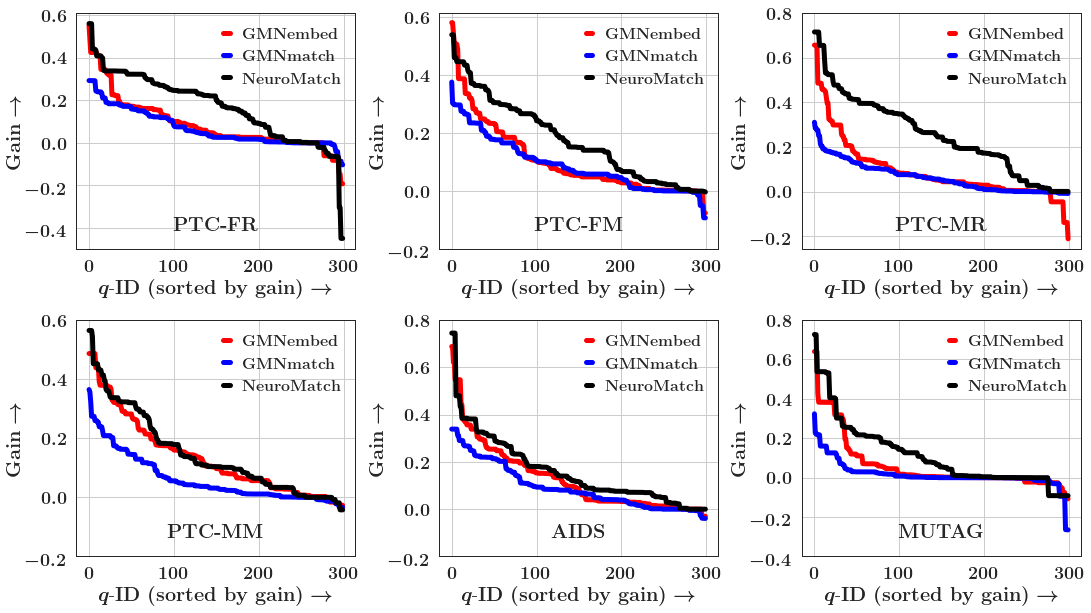

In [24]:
def plot_drill_down():
    
    import matplotlib
    %matplotlib inline
    from matplotlib import pyplot as plt
    import brewer2mpl
    bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
    color_list = bmap.mpl_colors
    color_list = [(0.4, 0.7607843137254902, 0.6470588235294118),
                 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
                 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
                 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
                 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
                 (1.0, 0.8509803921568627, 0.1843137254901961),
                 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
                 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

    color_list = [(1, 0, 0),
                 (0, 0, 1),
                  (0,0,0),
                 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
                 (0,0,0),
    #              (0.4, 0.7607843137254902, 0.6470588235294118),
                 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
                (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),]

    def latexify():
        matplotlib.rcParams['text.usetex'] = True
        matplotlib.rcParams['axes.spines.right'] = False
        matplotlib.rcParams['axes.spines.top'] = False
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
        matplotlib.rc('text', usetex=True)
        matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath,amsfonts} \usepackage{bm} \boldmath"
        plt.rc('axes', linewidth=1)
        plt.rc('font', weight='bold')


    latexify()

    
    fig, ((fr, fm, mr), (mm, aids, mutag)) = plt.subplots(2, 3, figsize=(18,10))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    data_ids={}
    data_ids['ptc_fr'], data_ids['ptc_fm'] = fr, fm
    data_ids['ptc_mr'], data_ids['ptc_mm'] = mr, mm
    data_ids['aids'], data_ids['mutag'] = aids, mutag
    latex_dataset={'ptc_fr':r'\textbf{PTC-FR}', 'ptc_fm':r'\textbf{PTC-FM}', 'ptc_mr':r'\textbf{PTC-MR}', 'ptc_mm':r'\textbf{PTC-MM}', 'aids':r'\textbf{AIDS}', 'mutag':r'\textbf{MUTAG}'}
    
    j=0
    
    for dataset in ["ptc_fr","ptc_fm", "ptc_mr", "ptc_mm","mutag","aids"]:
        i=-1
        for baseline in ['diff_gmnemb','diff_gmnmat','diff_nm']:
            i=i+1  
            label_map=[r'\textbf{GMN\-embed}',r'\textbf{GMN\-match}',r'\textbf{NeuroMatch}']    

            data_ids[dataset].plot(score_dict[dataset]['x'],score_dict[dataset][baseline], label=label_map[i], linewidth=5,
                            markersize=4, color=color_list[i])


        data_ids[dataset].set_xlabel(r'$q$-\textbf{ID} \textbf{(sorted by gain)} $\rightarrow$', fontsize=20)
        data_ids[dataset].set_xticks(list(range(0,400,100)))

        data_ids[dataset].legend(prop={'size': 16}, frameon=False,handlelength=0.4)
            
        if j in [0]:
            data_ids[dataset].set_ylabel(r'\textbf{Gain} $\rightarrow$ ', fontsize=20, labelpad=0)
            data_ids[dataset].set_yticks([-0.4, -0.2, 0.0, 0.2, 0.4, 0.6 ])
        elif j in [4]:
            data_ids[dataset].set_ylabel(r'\textbf{Gain} $\rightarrow$ ', fontsize=20, labelpad=0)
            data_ids[dataset].set_yticks([-0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8])
        elif j in [1, 3]:
            data_ids[dataset].set_ylabel(r'\textbf{Gain} $\rightarrow$ ', fontsize=20, labelpad=0)
            data_ids[dataset].set_yticks([-0.2, 0.0, 0.2, 0.4, 0.6 ])
        else:
            data_ids[dataset].set_ylabel(r'\textbf{Gain} $\rightarrow$ ', fontsize=20, labelpad=0)
            data_ids[dataset].set_yticks([-0.2, 0.0, 0.2, 0.4, 0.6, 0.8])


        data_ids[dataset].text(0.5, 0.1, latex_dataset[dataset], weight='bold', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=data_ids[dataset].transAxes)
        data_ids[dataset].grid(axis='y',linestyle='-', linewidth=1)
        data_ids[dataset].grid(axis='x',linestyle='-', linewidth=1)

        
        data_ids[dataset].spines['top'].set_visible(True)
        data_ids[dataset].spines['right'].set_visible(True)
        j += 1

    plt.box(on=True)
    file = "drill_down_300"+".pdf"
    plt.savefig(file, bbox_inches='tight') 
    plt.show()
plot_drill_down()

# Aligned Graph pairs

In [31]:
def fetch_data(source, batch):
    """
      source : train_data/test_data/val_data
      batch  : list of ((qid,cid),label)
               sometimes there may be score instead of label.
               Doesn't matter since unused
    """
    gq = [source.query_graphs[x[0][0]] for x in batch]
    gq_adj = [source.query_graph_adj_list[x[0][0]] for x in batch]
    gq_size = [source.query_graph_size_list[x[0][0]] for x in batch]

    gc = [source.corpus_graphs[x[0][1]] for x in batch]
    gc_adj = [source.corpus_graph_adj_list[x[0][1]] for x in batch]
    gc_size = [source.corpus_graph_size_list[x[0][1]] for x in batch]
    all_data =  source._pack_batch(zip(gq,gc))
    all_sizes = list(zip(gq_size,gc_size))
    all_adj = list(zip(gq_adj,gc_adj))
    return all_data, all_sizes, all_adj 

def fetch_graph_pair_edges_from_packed_data(all_data,d1,d2):
    """
      all_data contains packed version of exactly one graph pair
      d1,d2 - don't care
    """
    node_features, edge_features, from_idx, to_idx, graph_idx = bestM.get_graph(all_data)
    num_edges_q, num_edges_c = bestM.fetch_edge_counts(to_idx,from_idx,graph_idx,2)
    num_nodes_q = len(graph_idx[graph_idx==0])
    num_nodes_c = len(graph_idx[graph_idx==1])

    from_idx_q = from_idx[:num_edges_q]
    to_idx_q = to_idx[:num_edges_q]
    edges_q = list(zip(from_idx_q.tolist(),to_idx_q.tolist()))

    from_idx_c = from_idx[num_edges_q:]
    to_idx_c = to_idx[num_edges_q:]
    edges_c = list(zip(from_idx_c.tolist(),to_idx_c.tolist()))

    edges_q_pad = [str((x[0],x[1])) for x in edges_q]+  ['dummy'] * (av.MAX_EDGES - len(edges_q))
    edges_c_pad = [str((x[0]-num_nodes_q,x[1]-num_nodes_q)) for x in edges_c]+  ['dummy'] * (av.MAX_EDGES - len(edges_c))
    return edges_q_pad, edges_c_pad

In [32]:
data_pair_dict = {}
data_pair_dict[1] = {'dataset':'ptc_mm', 'g_ids':((7, 563), 1)}
data_pair_dict[2] = {'dataset':'ptc_mr', 'g_ids':((15, 52), 1)}
data_pair_dict[3] = {'dataset':'ptc_mr', 'g_ids':((10, 236), 1)}
data_pair_dict[4] = {'dataset':'aids', 'g_ids':((22, 183), 1)}
data_pair_dict[5] = {'dataset':'ptc_fm', 'g_ids':((2, 569), 1)}
data_pair_dict[6] = {'dataset':'ptc_fr', 'g_ids':((0, 510), 1)}
data_pair_dict[7] = {'dataset':'ptc_fr', 'g_ids':((13, 17), 1)}

def plot_q_graph():

    import matplotlib
    %matplotlib inline
    from matplotlib import pyplot as plt
    import brewer2mpl
    bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
    color_list = bmap.mpl_colors

    def latexify():
        matplotlib.rcParams['text.usetex'] = True
        matplotlib.rcParams['axes.spines.right'] = False
        matplotlib.rcParams['axes.spines.top'] = False
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=60)
        plt.rc('ytick', labelsize=60)
        matplotlib.rc('text', usetex=True)
        matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath,amsfonts} \usepackage{bm} \boldmath"
        plt.rc('axes', linewidth=1)
        plt.rc('font', weight='bold')

    latexify()

    #i=-1
    
    fig, ax = plt.subplots(figsize=(15,14))
    
    
    q_G = test_data.query_graphs[data_pair[0][0]]
    c_G = test_data.corpus_graphs[data_pair[0][1]]
    
    q_pos = nx.kamada_kawai_layout(q_G)
    edge_color_list = ["#DC143C", "#FF1493", "#C71585", "#FF8C00", "#663399", "#9400D3", "#4B0082", "#3CB371", "#228B22", "#0000FF", "#A52A2A", "#DEB887", "#DAA520", "#BDB76B", "#FFD700"]
    q_colors = ["#F70922", "#F804C7", "#6104F8", "#3C498B", "#919CA1", "#656A6A", "#2CB86B", "#1DF729", "#E4F905", "#DA9503"]
    n_q = len(q_G.edges())
    q_e_labels={edge:str(idx) for idx, edge in enumerate(q_G.edges())}
    #q_cmap = sns.diverging_palette(250, 15, s=80, l=80, n=n_q, center="dark", as_cmap=True)
    q_cmap = plt.cm.tab20c

    q_options = {
        "node_color": "#D3D3D3",
        "edgecolors": "black",
        #"edge_color": "#2E3E70",
        "edge_color": [edge_color_list[i] for i in range(len(q_G.edges()))],
        "node_size": 4000,
        "width": 20,
        #"edge_labels": e_labels,
        #"edge_cmap": plt.cm.tab20c,
        #"edge_cmap": q_cmap,
        "alpha": 1,
        "linewidths": 3,
        "with_labels": False,
    }

    nx.draw(q_G, q_pos, ax=ax, **q_options)
    
    plt.box(on=True)
    #file = "query_graph7"+".pdf"
    #plt.savefig(file, bbox_inches='tight')
    plt.show()
    
def plot_c_graph():

    import matplotlib
    %matplotlib inline
    from matplotlib import pyplot as plt
    import brewer2mpl
    bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
    color_list = bmap.mpl_colors

    def latexify():
        matplotlib.rcParams['text.usetex'] = True
        matplotlib.rcParams['axes.spines.right'] = False
        matplotlib.rcParams['axes.spines.top'] = False
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=60)
        plt.rc('ytick', labelsize=60)
        matplotlib.rc('text', usetex=True)
        matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath,amsfonts} \usepackage{bm} \boldmath"
        plt.rc('axes', linewidth=1)
        plt.rc('font', weight='bold')

    latexify()

    #i=-1
    
    fig, ax = plt.subplots(figsize=(15,14))
    
    q_G = test_data.query_graphs[data_pair[0][0]]
    c_G = test_data.corpus_graphs[data_pair[0][1]]
    
    c_pos = nx.kamada_kawai_layout(c_G)
    edge_color_list = ["#DC143C", "#FF1493", "#C71585", "#FF8C00", "#663399", "#9400D3", "#4B0082", "#3CB371", "#228B22", "#0000FF", "#A52A2A", "#DEB887", "#DAA520", "#BDB76B", "#FFD700"]
    c_colors = ["#F70922", "#F804C7", "#6104F8", "#3C498B", "#919CA1", "#656A6A", "#2CB86B", "#1DF729", "#E4F905", "#DA9503", "#4B2508", "#CE1D0C", ]
    n_c = len(c_G.edges())
    c_e_labels={edge:str(idx) for idx, edge in enumerate(q_G.edges())}
    #c_cmap = sns.diverging_palette(250, 15, s=80, l=80, n=n_q, center="dark", as_cmap=True)
    c_cmap = plt.cm.tab20c

    qe_to_id = {"("+str(q_e[0])+", "+str(q_e[1])+")":id for id, q_e in enumerate(q_G.edges())}
    qe_to_id["dummy"] = 14
    c_options = {
        "node_color": "#D3D3D3",
        "edgecolors": "black",
        #"edge_color": "#2E3E70",
        #"edge_color": [edge_color_list[i] for i in range(len(c_G.edges()))],
        "edge_color": [edge_color_list[qe_to_id[cq_edge_alignment["("+str(c_e[0])+", "+str(c_e[1])+")"]]] for c_e in c_G.edges()],
        "node_size": 4000,
        "width": 20,
        #"edge_labels": e_labels,
        #"edge_cmap": plt.cm.tab20c,
        #"edge_cmap": q_cmap,
        "linewidths": 3,
        "alpha": 1,
        "with_labels": False,
    }

    nx.draw(c_G, c_pos, ax=ax, **c_options)
    
    
    plt.box(on=True)
    #file = "corpus_graph"+".pdf"
    #plt.savefig(file, bbox_inches='tight')
    plt.show()
    
def plot_soft_heatmap():

    import matplotlib
    import matplotlib as mpl
    %matplotlib inline
    from matplotlib import pyplot as plt
    import brewer2mpl
    bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
    color_list = bmap.mpl_colors
    color_list = [(0.4, 0.7607843137254902, 0.6470588235294118),
                 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
                 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
                 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
                 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
                 (1.0, 0.8509803921568627, 0.1843137254901961),
                 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
                 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

    color_list = [(1, 0, 0),
                 (0, 0, 1),
                  (0,0,0),
                 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
                 (0,0,0),
    #              (0.4, 0.7607843137254902, 0.6470588235294118),
                 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
                (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),]

    def latexify():
        matplotlib.rcParams['text.usetex'] = True
        matplotlib.rcParams['axes.spines.right'] = False
        matplotlib.rcParams['axes.spines.top'] = False
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=60)
        plt.rc('ytick', labelsize=60)
        matplotlib.rc('text', usetex=True)
        matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath,amsfonts} \usepackage{bm} \boldmath"
        plt.rc('axes', linewidth=1)
        plt.rc('font', weight='bold')


    latexify()

    fig, axn = plt.subplots(figsize=(15,8))
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0.15)
    cbar_ax = fig.add_axes([0.78, 0.0003, 0.045, 0.999])
    
    q_G = test_data.query_graphs[data_pair[0][0]]
    c_G = test_data.corpus_graphs[data_pair[0][1]]

    cmap = plt.cm.tab20c
    edge_color_list = ["#DC143C", "#FF1493", "#C71585", "#FF8C00", "#663399", "#9400D3", "#4B0082", "#3CB371", "#228B22", "#0000FF", "#A52A2A", "#DEB887", "#DAA520", "#BDB76B", "#FFD700"]
    #q_cmaplist = ([cmap(i) for i in range(len(q_G.edges()))] + [cmap(20)]*(len(c_G.edges()) - len(q_G.edges())))[::-1]
    q_cmaplist = ([edge_color_list[i] for i in range(len(q_G.edges()))] + [edge_color_list[-1]]*(len(c_G.edges()) - len(q_G.edges())))[::-1]
    q_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'q_edge_color_cmap', q_cmaplist, len(c_G.edges()))

    #c_cmaplist = [edge_color_list[i] for i in range(len(c_G.edges()))]
    c_cmaplist = ([edge_color_list[i] for i in range(len(q_G.edges()))] + [edge_color_list[-1]]*(len(c_G.edges()) - len(q_G.edges())))
    c_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'c_edge_color_cmap', c_cmaplist, len(c_G.edges()))

    # define the bins and normalize
    bounds = np.linspace(0, len(c_G.edges()), len(c_G.edges())+1)
    q_norm = mpl.colors.BoundaryNorm(bounds, q_cmap.N)
    c_norm = mpl.colors.BoundaryNorm(bounds, c_cmap.N)

    ax_y1 = fig.add_axes([0.182, 0.0003, 0.045, 0.999])
    cb_y1 = mpl.colorbar.ColorbarBase(ax_y1, cmap=q_cmap, norm=q_norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
    cb_y1.set_ticks([])

    ax_x1 = fig.add_axes([0.2325, -0.09, 0.534, 0.08])
    cb_x1 = mpl.colorbar.ColorbarBase(ax_x1, cmap=c_cmap, norm=c_norm, orientation="horizontal",
            spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
    cb_x1.set_ticks([])

    ce_to_id = {"("+str(c_e[0])+", "+str(c_e[1])+")":id for id, c_e in enumerate(c_G.edges())}
    
    alignment_permutation = [ce_to_id[c_e] for q_e, c_e in qc_edge_alignment] 
    
    for i, ax in enumerate([axn]):
        if i==0:
            sns.heatmap(dum_alignment[:,alignment_permutation], cmap="Blues", ax=ax,
                    cbar=i == 0, xticklabels=False, yticklabels=False, cbar_kws={'ticks':[0.0, 1.0]},
                    vmin=0.0, vmax=1.0, square=True,
                    cbar_ax=None if i else cbar_ax)
        else:
            sns.heatmap(np.eye(dum_alignment.shape[1])[col_ind][:, alignment_permutation], cmap="Blues", ax=ax,
                    cbar=i == 0, xticklabels=False, yticklabels=False, cbar_kws={'ticks':[0.0, 1.0]},
                    vmin=0, vmax=1, square=True,
                    cbar_ax=None if i else cbar_ax)
            
        plt.box(on=True)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        
    cbar = axn.collections[0].colorbar
    
    axn.set_ylabel(r'$E_q\rightarrow$', fontsize=60, labelpad=70)
    axn.set_xlabel(r'$E_c\rightarrow$', fontsize=60, labelpad=70)

    

    #file = "soft_heatmap"+".pdf"
    #plt.savefig(file, bbox_inches='tight')
    plt.show()
    
def plot_hard_heatmap():

    import matplotlib
    import matplotlib as mpl
    %matplotlib inline
    from matplotlib import pyplot as plt
    import brewer2mpl
    bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
    color_list = bmap.mpl_colors
    color_list = [(0.4, 0.7607843137254902, 0.6470588235294118),
                 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
                 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
                 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
                 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
                 (1.0, 0.8509803921568627, 0.1843137254901961),
                 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
                 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

    color_list = [(1, 0, 0),
                 (0, 0, 1),
                  (0,0,0),
                 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
                 (0,0,0),
    #              (0.4, 0.7607843137254902, 0.6470588235294118),
                 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
                (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),]

    def latexify():
        matplotlib.rcParams['text.usetex'] = True
        matplotlib.rcParams['axes.spines.right'] = False
        matplotlib.rcParams['axes.spines.top'] = False
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=60)
        plt.rc('ytick', labelsize=60)
        matplotlib.rc('text', usetex=True)
        matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath,amsfonts} \usepackage{bm} \boldmath"
        plt.rc('axes', linewidth=1)
        plt.rc('font', weight='bold')


    latexify()

    fig, axn = plt.subplots(figsize=(15,8))
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0.15)
    cbar_ax = fig.add_axes([0.78, 0.0003, 0.045, 0.999])
    
    q_G = test_data.query_graphs[data_pair[0][0]]
    c_G = test_data.corpus_graphs[data_pair[0][1]]

    cmap = plt.cm.tab20c
    edge_color_list = ["#DC143C", "#FF1493", "#C71585", "#FF8C00", "#663399", "#9400D3", "#4B0082", "#3CB371", "#228B22", "#0000FF", "#A52A2A", "#DEB887", "#DAA520", "#BDB76B", "#FFD700"]
    #q_cmaplist = ([cmap(i) for i in range(len(q_G.edges()))] + [cmap(20)]*(len(c_G.edges()) - len(q_G.edges())))[::-1]
    q_cmaplist = ([edge_color_list[i] for i in range(len(q_G.edges()))] + [edge_color_list[-1]]*(len(c_G.edges()) - len(q_G.edges())))[::-1]
    q_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'q_edge_color_cmap', q_cmaplist, len(c_G.edges()))

    #c_cmaplist = [edge_color_list[i] for i in range(len(c_G.edges()))]
    c_cmaplist = ([edge_color_list[i] for i in range(len(q_G.edges()))] + [edge_color_list[-1]]*(len(c_G.edges()) - len(q_G.edges())))
    c_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'c_edge_color_cmap', c_cmaplist, len(c_G.edges()))

    # define the bins and normalize
    bounds = np.linspace(0, len(c_G.edges()), len(c_G.edges())+1)
    q_norm = mpl.colors.BoundaryNorm(bounds, q_cmap.N)
    c_norm = mpl.colors.BoundaryNorm(bounds, c_cmap.N)

    ax_y1 = fig.add_axes([0.182, 0.0003, 0.045, 0.999])
    cb_y1 = mpl.colorbar.ColorbarBase(ax_y1, cmap=q_cmap, norm=q_norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
    cb_y1.set_ticks([])

    ax_x1 = fig.add_axes([0.2325, -0.09, 0.534, 0.08])
    cb_x1 = mpl.colorbar.ColorbarBase(ax_x1, cmap=c_cmap, norm=c_norm, orientation="horizontal",
            spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
    cb_x1.set_ticks([])

    ce_to_id = {"("+str(c_e[0])+", "+str(c_e[1])+")":id for id, c_e in enumerate(c_G.edges())}
    
    alignment_permutation = [ce_to_id[c_e] for q_e, c_e in qc_edge_alignment] 
    
    for i, ax in enumerate([axn]):
        if i==0:
            sns.heatmap(np.eye(dum_alignment.shape[1])[col_ind][:, alignment_permutation], cmap="Blues", ax=ax,
                    cbar=i == 0, xticklabels=False, yticklabels=False, cbar_kws={'ticks':[0.0, 1.0]},
                    vmin=0, vmax=1, square=True,
                    cbar_ax=None if i else cbar_ax)
        else:
            sns.heatmap(dum_alignment[:,alignment_permutation], cmap="Blues", ax=ax,
                    cbar=i == 0, xticklabels=False, yticklabels=False, cbar_kws={'ticks':[0.0, 1.0]},
                    vmin=0.0, vmax=1.0, square=True,
                    cbar_ax=None if i else cbar_ax)
            
            
        plt.box(on=True)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        
    cbar = axn.collections[0].colorbar
    #cbar.ax.set_yticklabels([0.0, 1.0], ["{:4.2f}".format(i) for i in [0.0, 1.0]])
    
    # here set the labelsize by 20
    #cbar.ax.tick_params(labelsize=32)
    
    axn.set_ylabel(r'$E_q\rightarrow$', fontsize=60, labelpad=70)
    axn.set_xlabel(r'$E_c\rightarrow$', fontsize=60, labelpad=70)

    

    #file = "hard_heatmap"+".pdf"
    #plt.savefig(file, bbox_inches='tight')
    plt.show()

loading test query graphs from ./Datasets/splits/test/test_ptc_mm80k_query_subgraphs.pkl
loading test relationships from ./Datasets/splits/test/test_ptc_mm80k_rel_nx_is_subgraph_iso.pkl
loading corpus graphs from ./Datasets/splits/ptc_mm80k_corpus_subgraphs.pkl
loading best validated model from ./bestValidationModels/matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1_ptc_mm


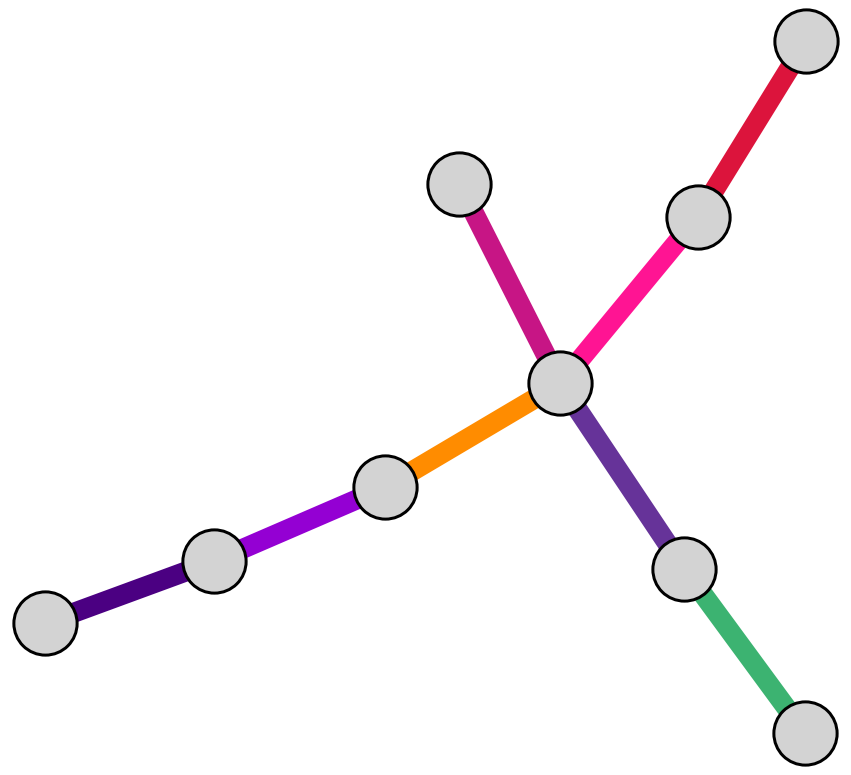

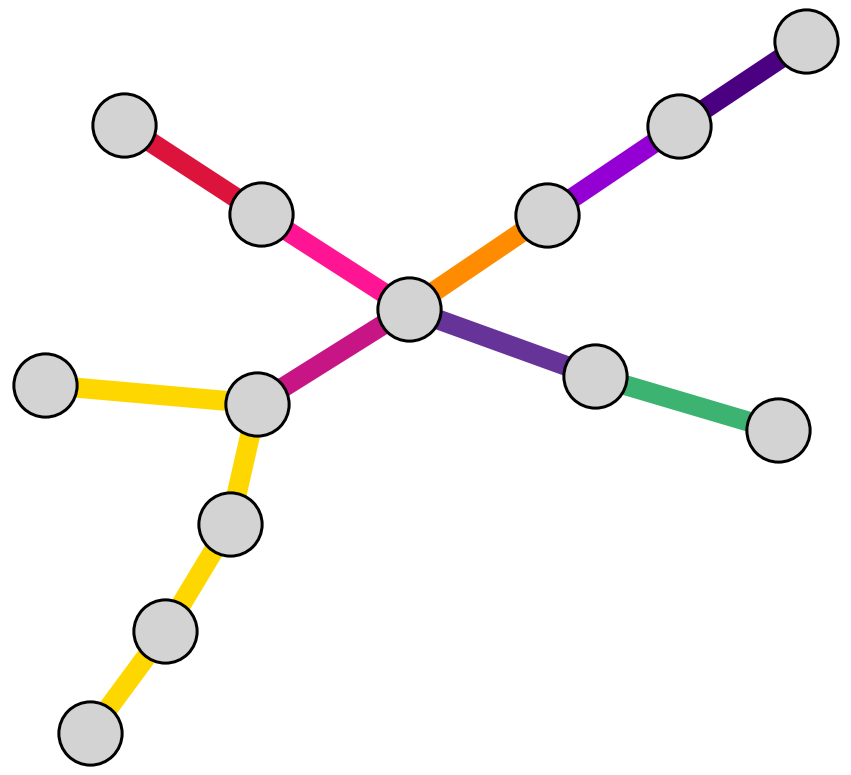

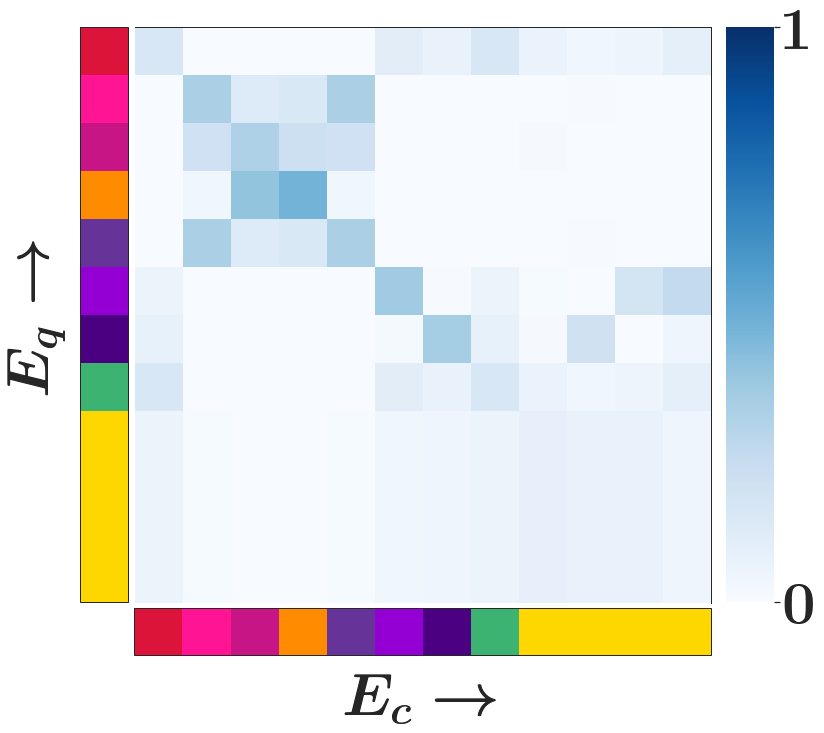

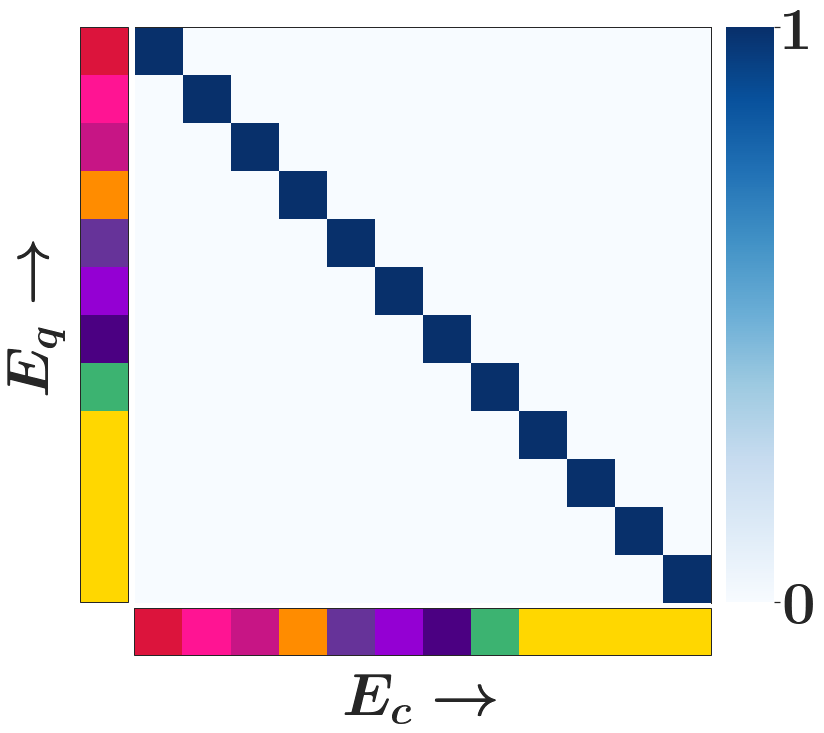

loading test query graphs from ./Datasets/splits/test/test_ptc_mm80k_query_subgraphs.pkl
loading test relationships from ./Datasets/splits/test/test_ptc_mm80k_rel_nx_is_subgraph_iso.pkl
loading corpus graphs from ./Datasets/splits/ptc_mm80k_corpus_subgraphs.pkl
loading best validated model from ./bestValidationModels/matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1_ptc_mm


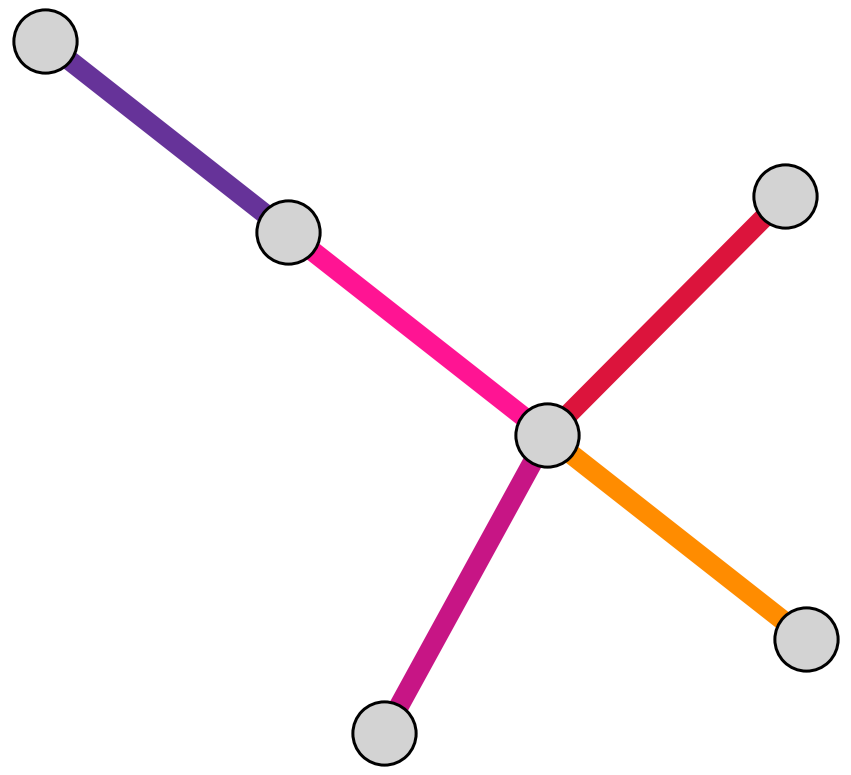

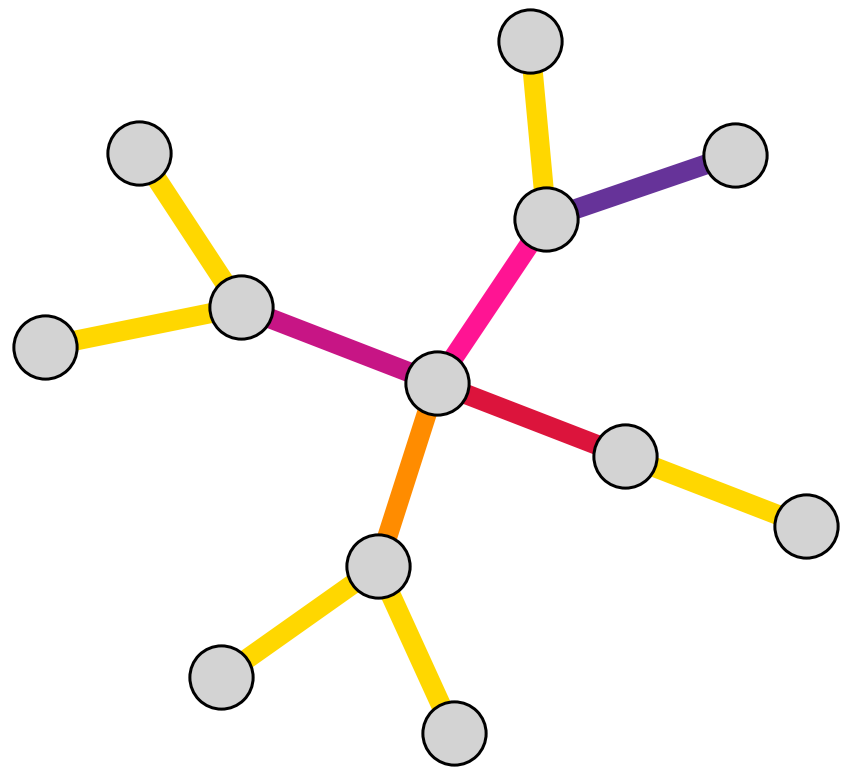

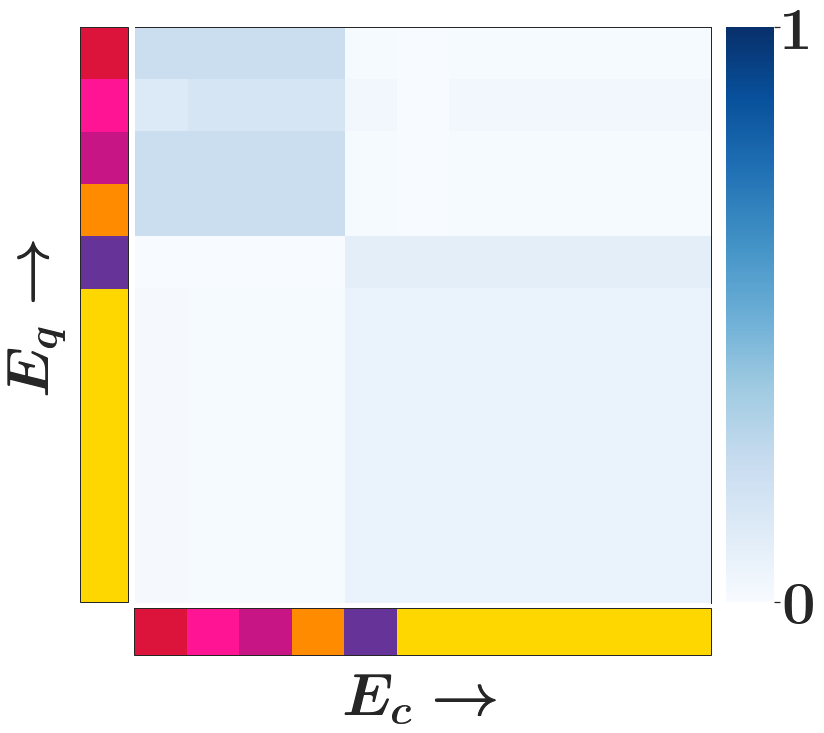

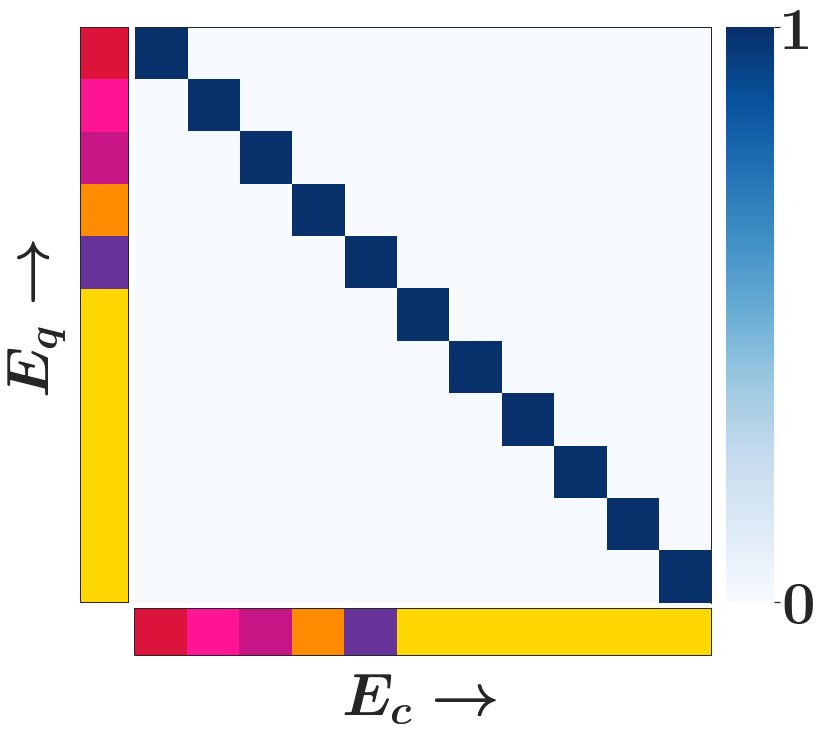

loading test query graphs from ./Datasets/splits/test/test_ptc_mm80k_query_subgraphs.pkl
loading test relationships from ./Datasets/splits/test/test_ptc_mm80k_rel_nx_is_subgraph_iso.pkl
loading corpus graphs from ./Datasets/splits/ptc_mm80k_corpus_subgraphs.pkl
loading best validated model from ./bestValidationModels/matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1_ptc_mm


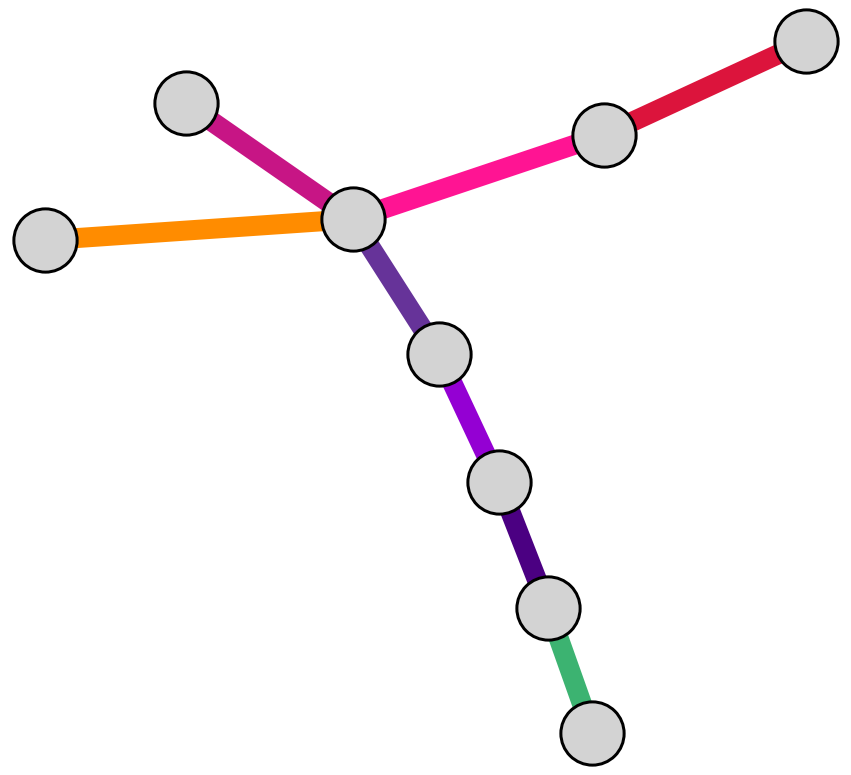

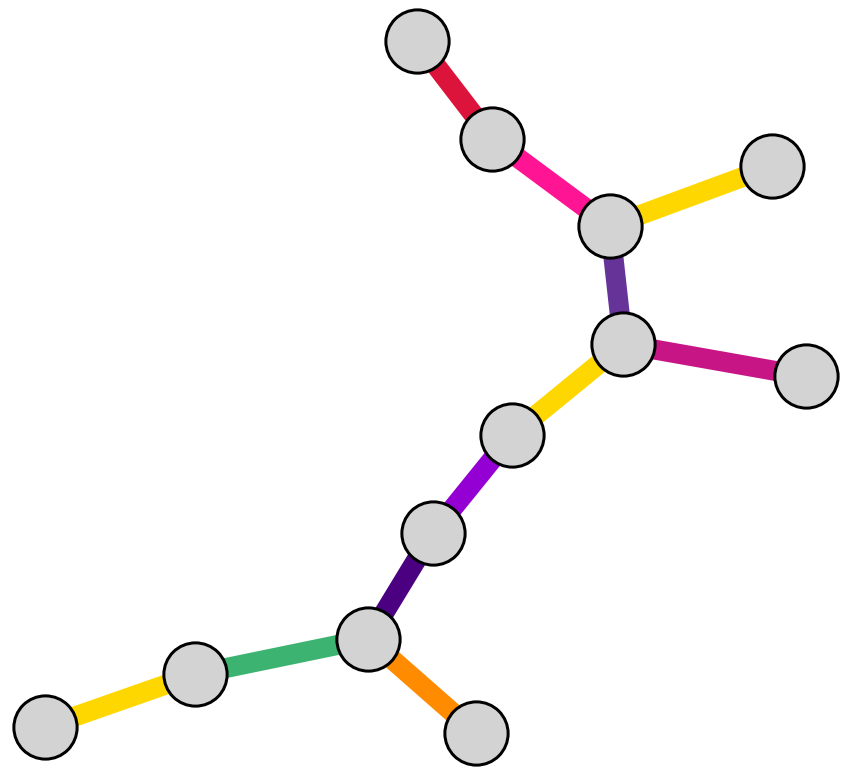

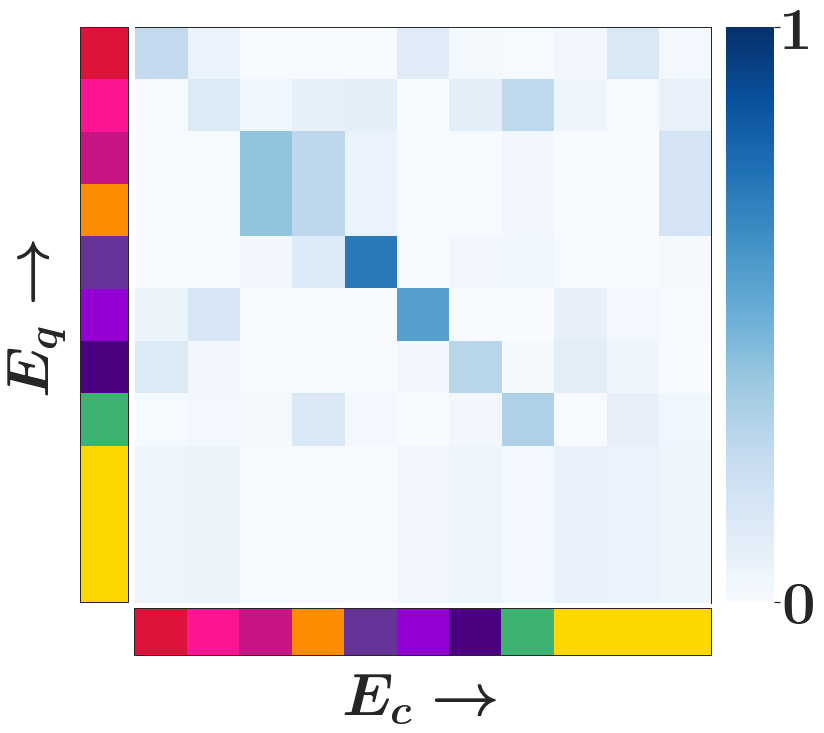

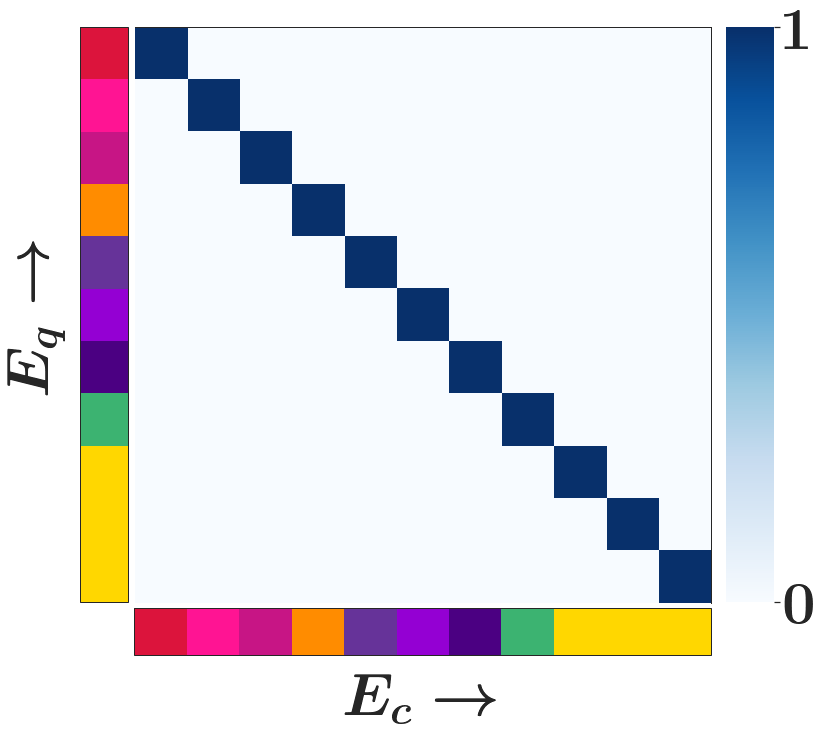

loading test query graphs from ./Datasets/splits/test/test_ptc_mm80k_query_subgraphs.pkl
loading test relationships from ./Datasets/splits/test/test_ptc_mm80k_rel_nx_is_subgraph_iso.pkl
loading corpus graphs from ./Datasets/splits/ptc_mm80k_corpus_subgraphs.pkl
loading best validated model from ./bestValidationModels/matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1_ptc_mm


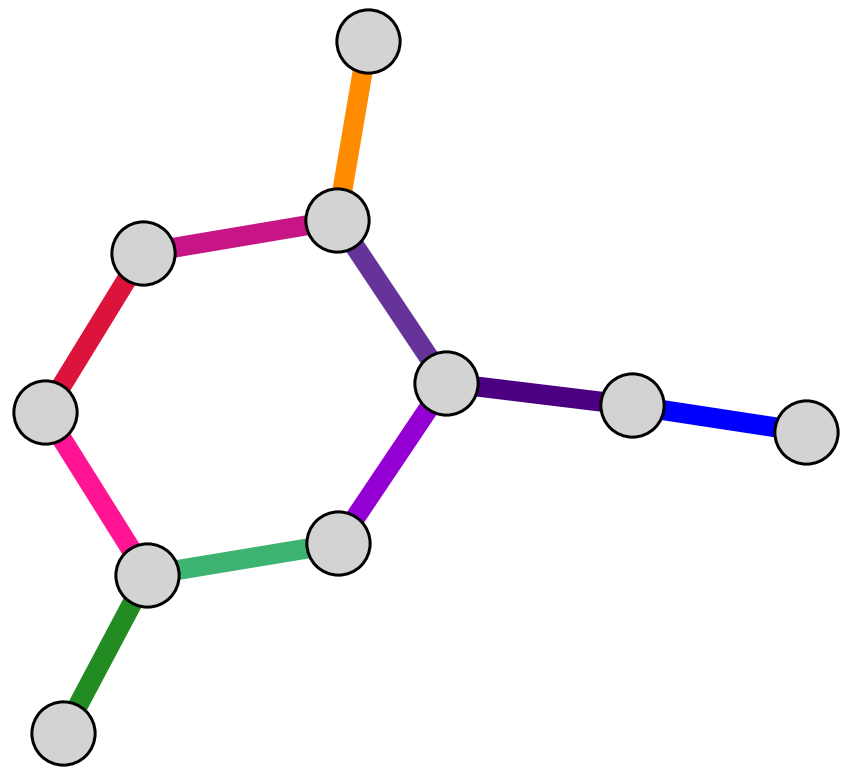

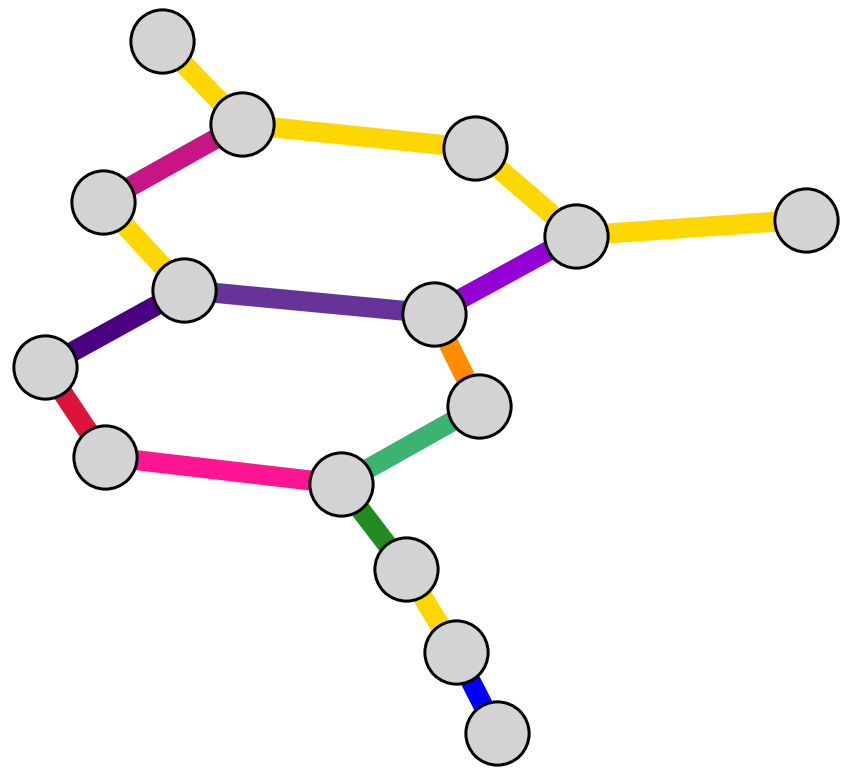

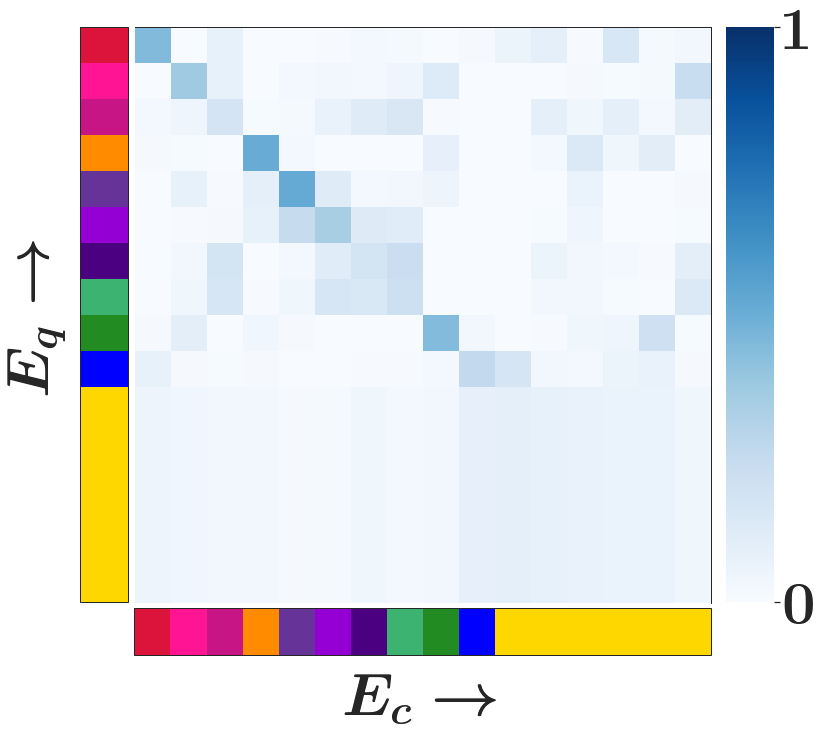

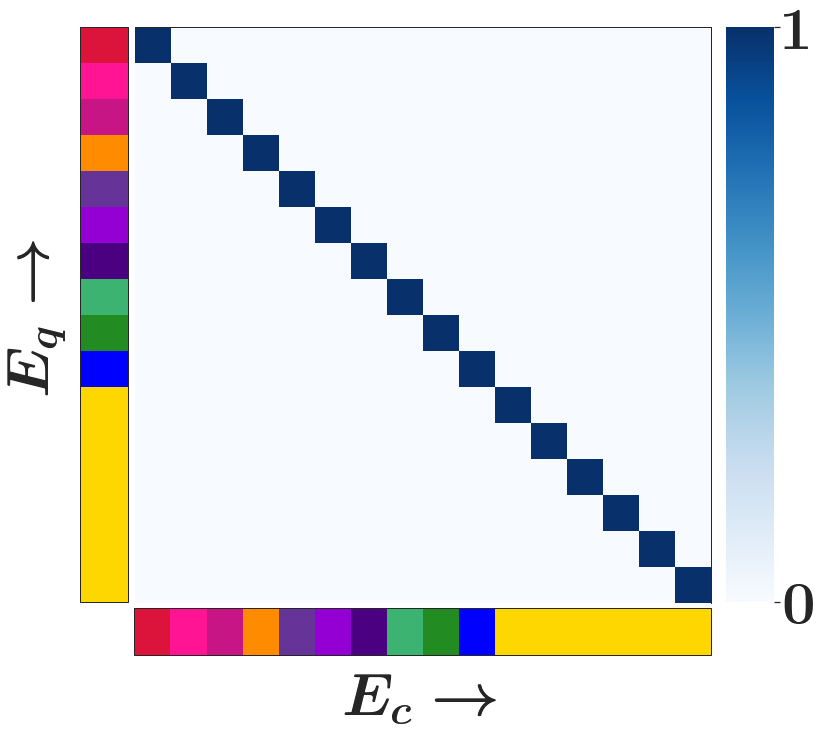

loading test query graphs from ./Datasets/splits/test/test_ptc_mm80k_query_subgraphs.pkl
loading test relationships from ./Datasets/splits/test/test_ptc_mm80k_rel_nx_is_subgraph_iso.pkl
loading corpus graphs from ./Datasets/splits/ptc_mm80k_corpus_subgraphs.pkl
loading best validated model from ./bestValidationModels/matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1_ptc_mm


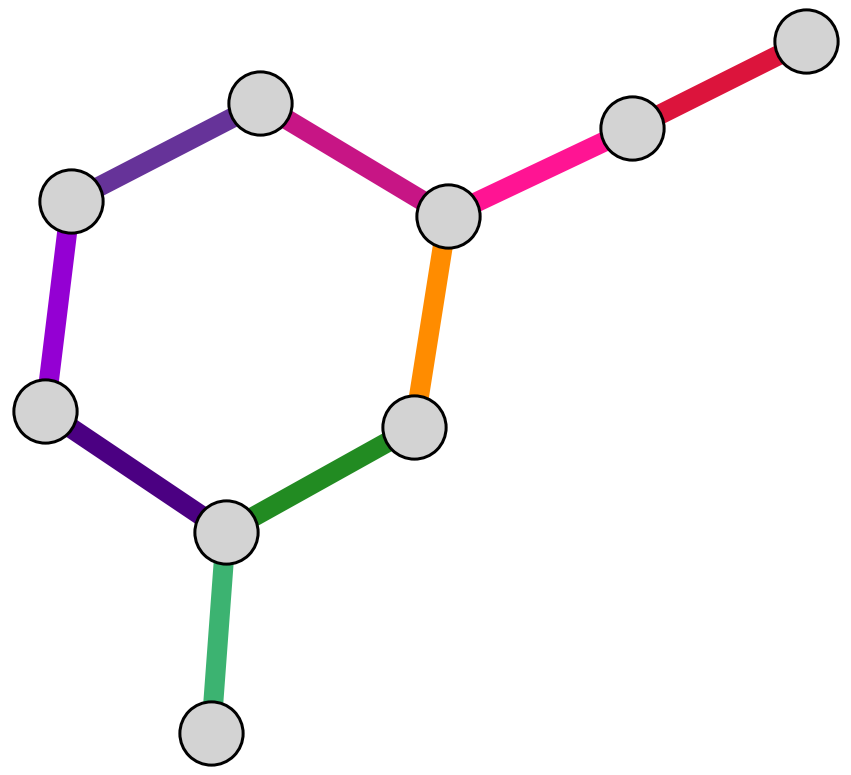

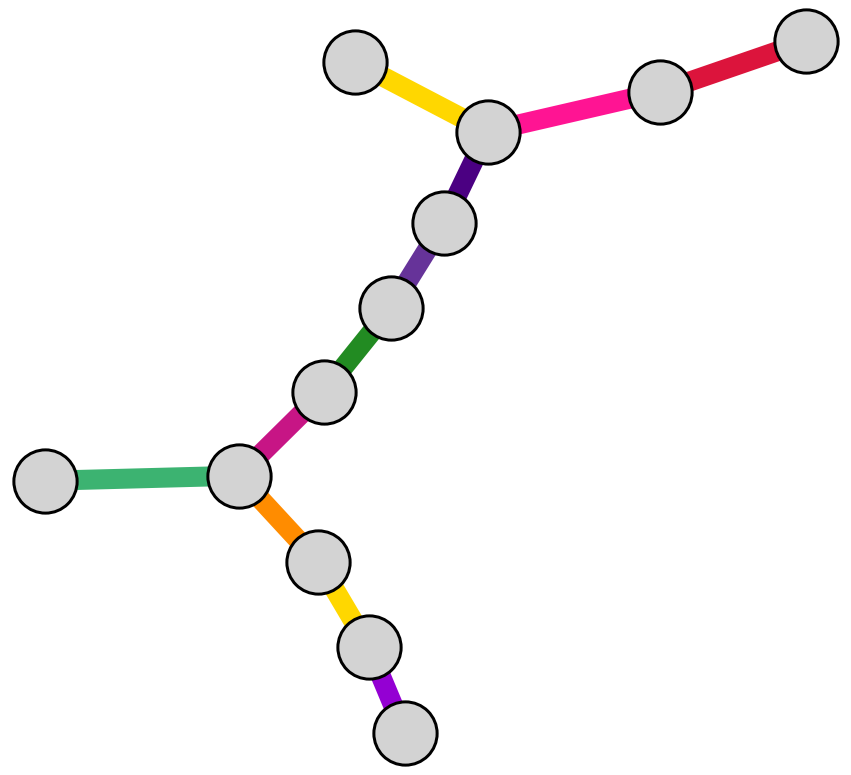

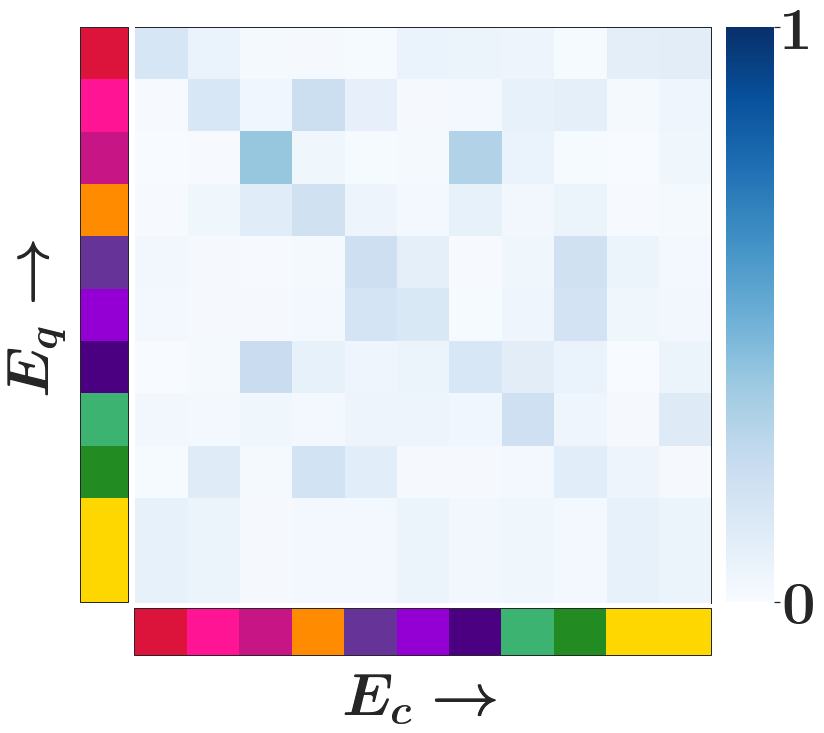

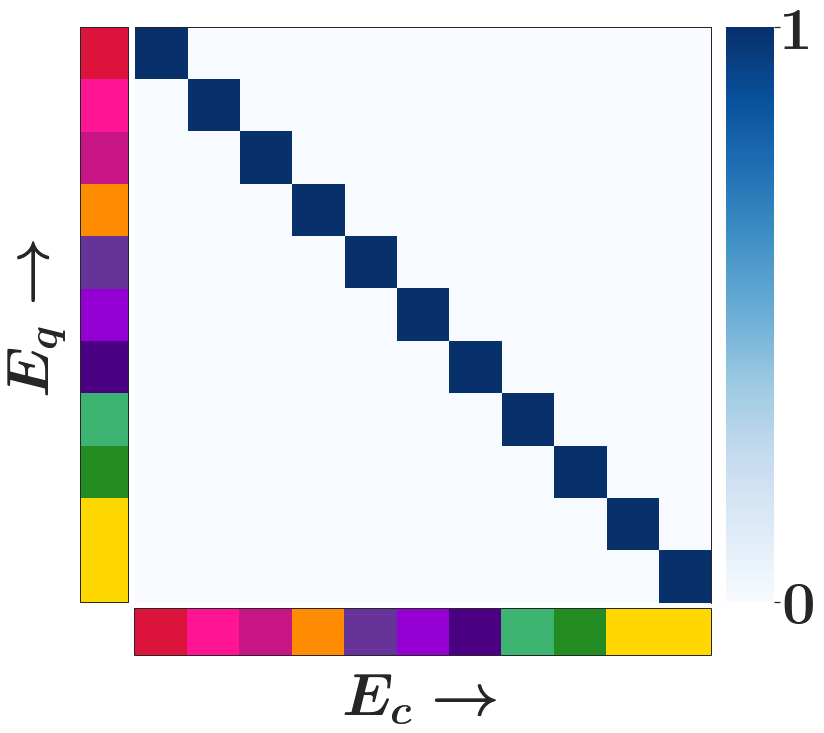

loading test query graphs from ./Datasets/splits/test/test_ptc_mm80k_query_subgraphs.pkl
loading test relationships from ./Datasets/splits/test/test_ptc_mm80k_rel_nx_is_subgraph_iso.pkl
loading corpus graphs from ./Datasets/splits/ptc_mm80k_corpus_subgraphs.pkl
loading best validated model from ./bestValidationModels/matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1_ptc_mm


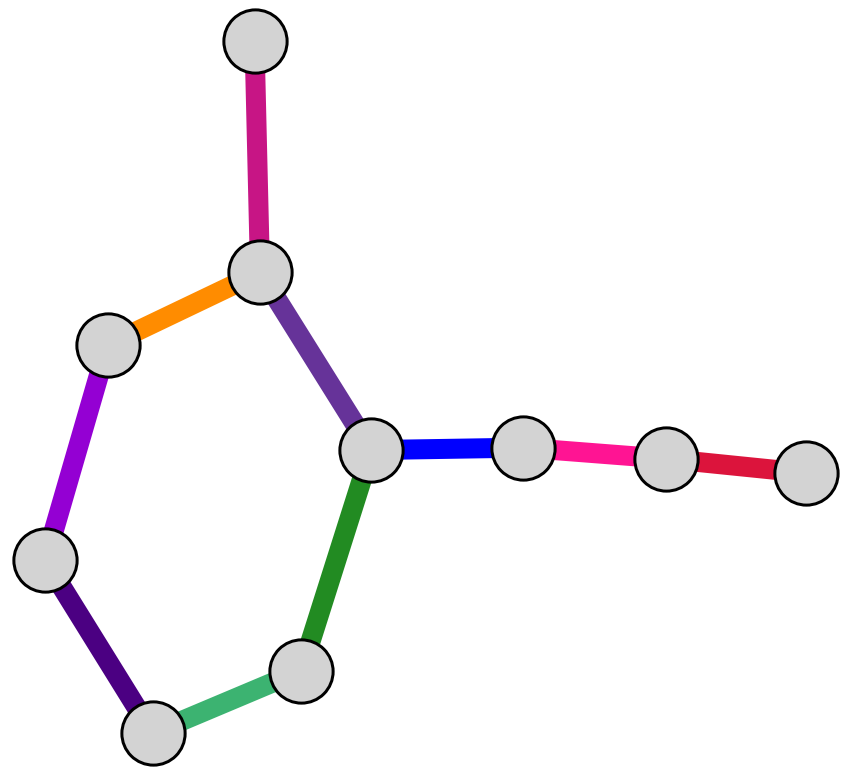

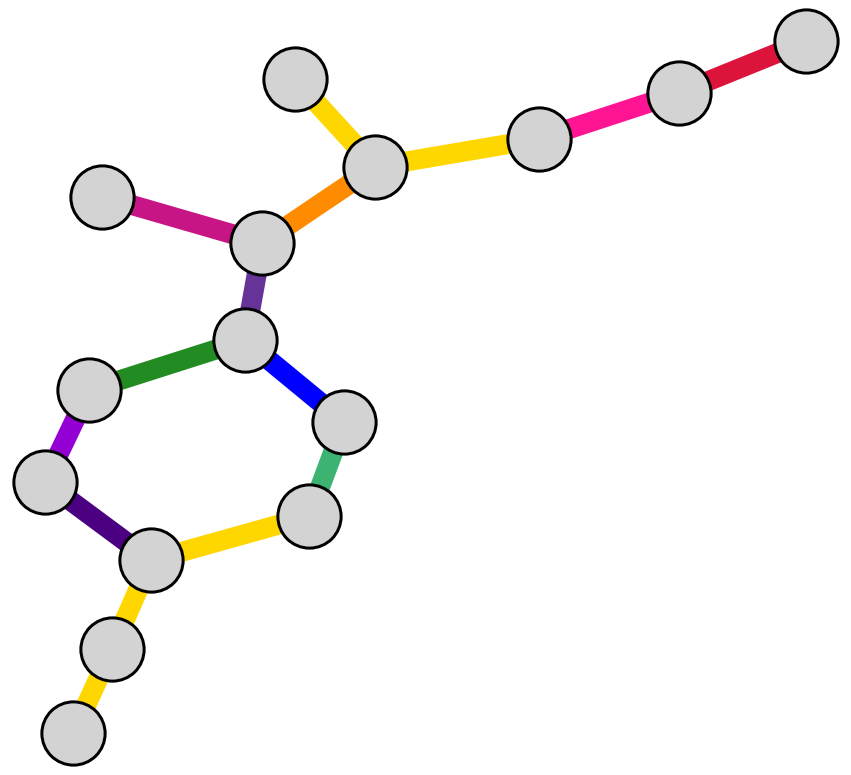

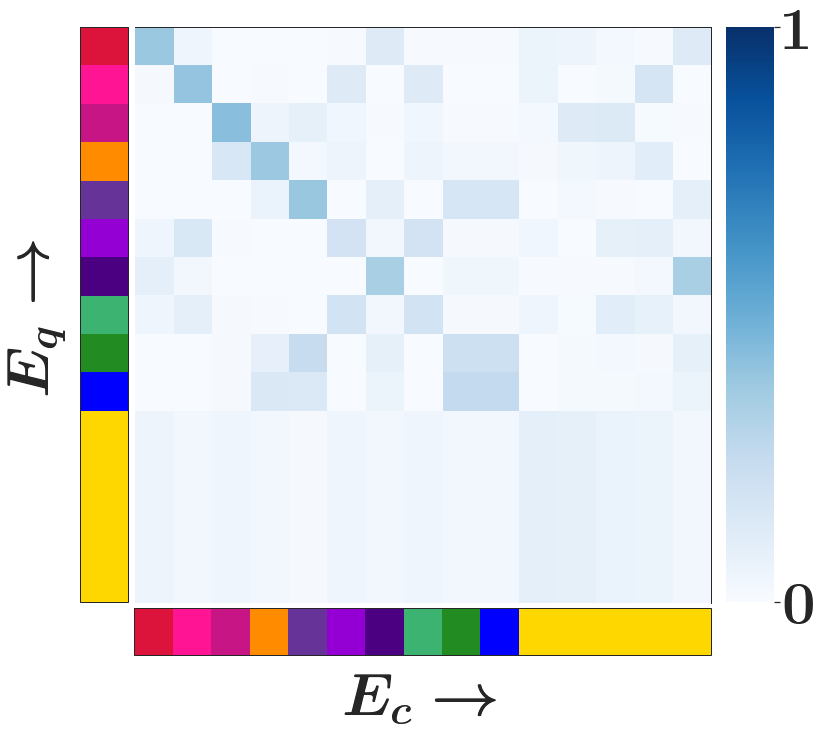

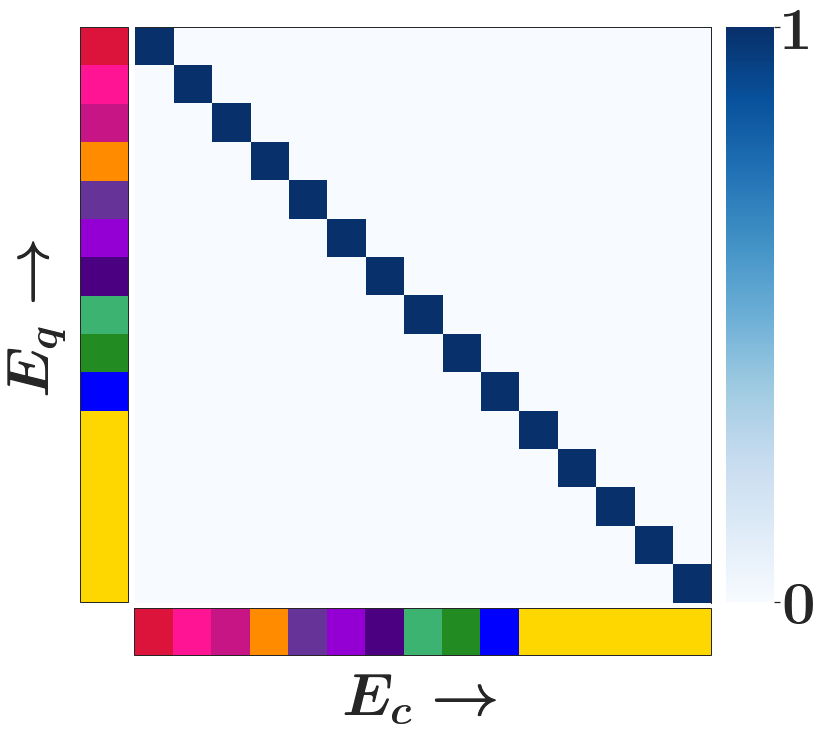

loading test query graphs from ./Datasets/splits/test/test_ptc_mm80k_query_subgraphs.pkl
loading test relationships from ./Datasets/splits/test/test_ptc_mm80k_rel_nx_is_subgraph_iso.pkl
loading corpus graphs from ./Datasets/splits/ptc_mm80k_corpus_subgraphs.pkl
loading best validated model from ./bestValidationModels/matching_iso_var_27_gmn_edge_perm_sinkhorn_param_big_hinge_score_on_edges_run1_corrected_noise0_margin2E-1_ptc_mm


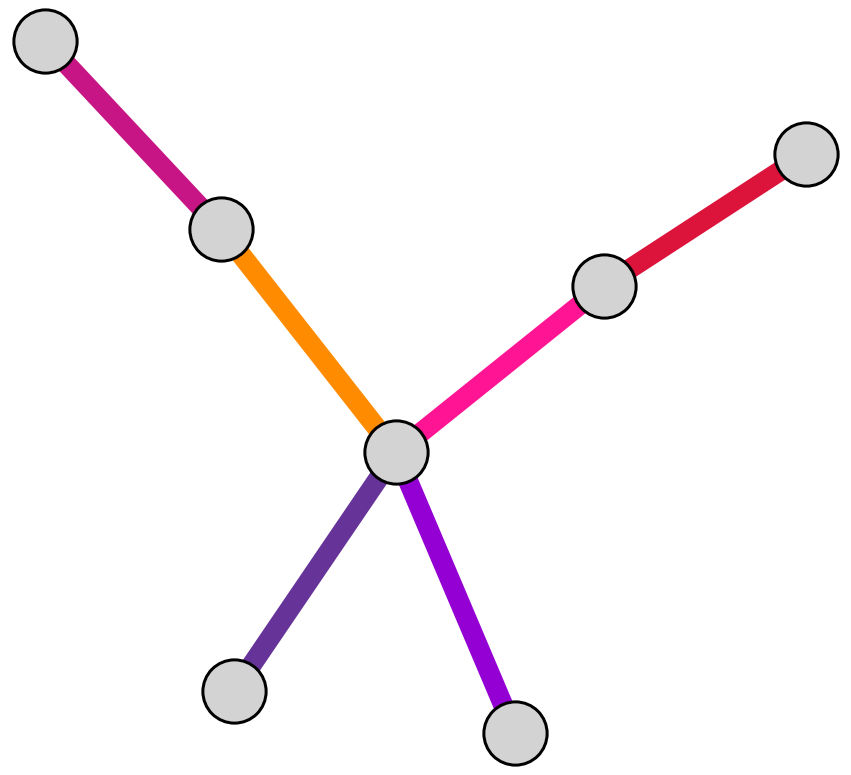

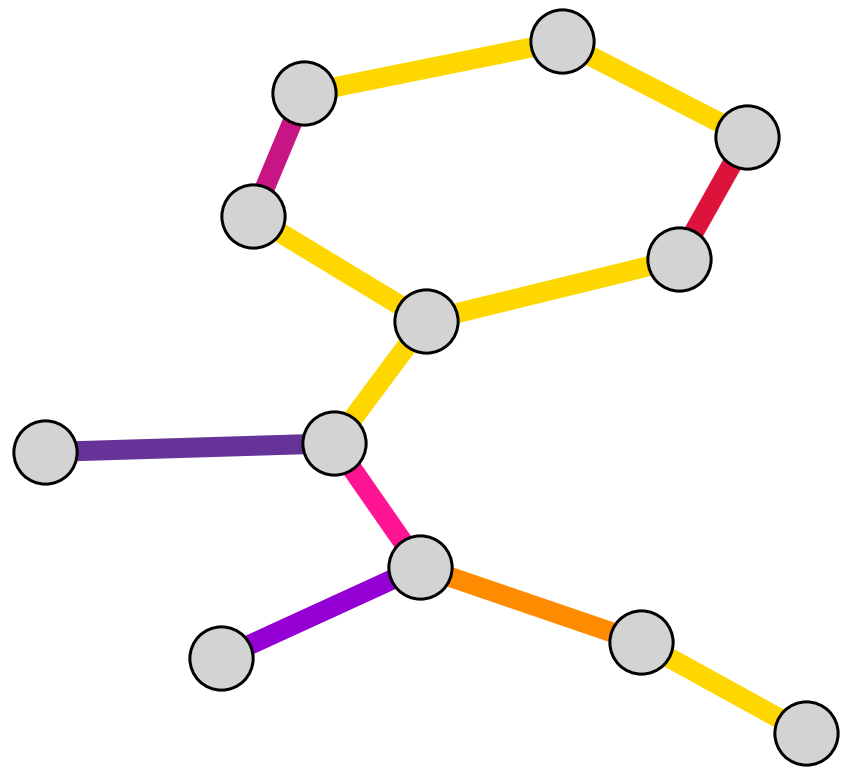

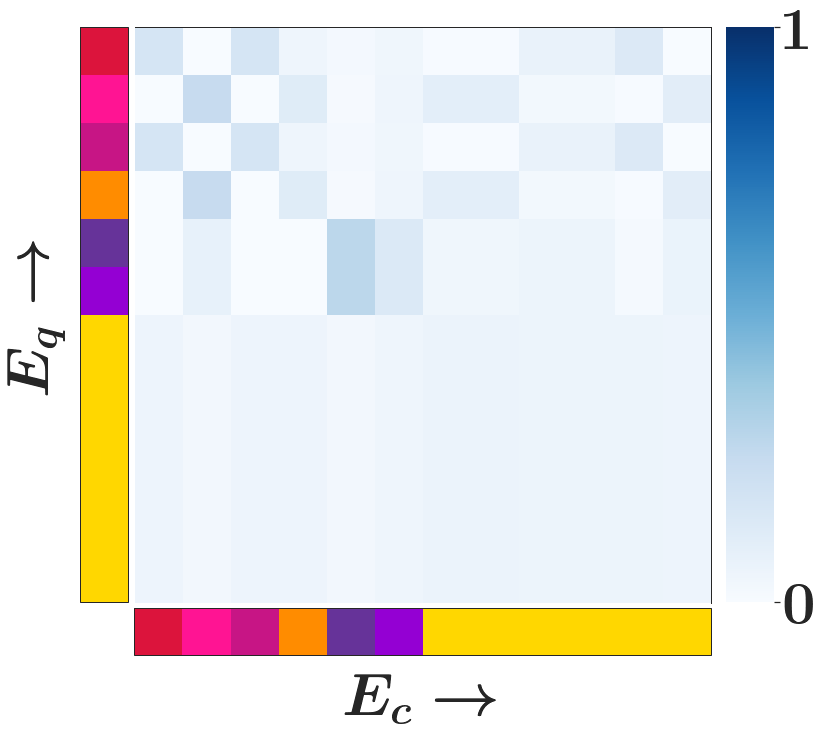

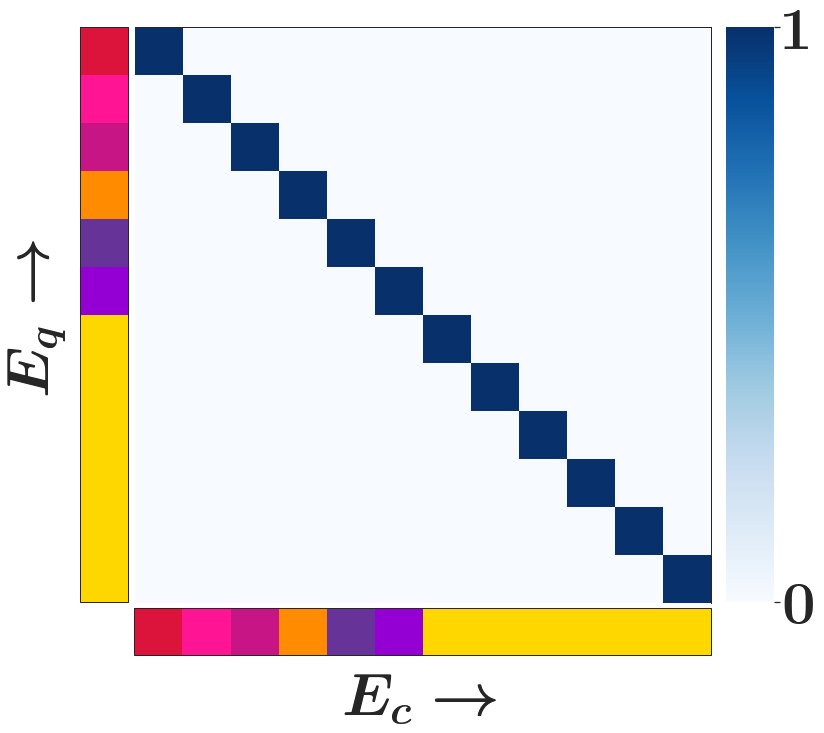

In [35]:
for i in data_pair_dict.keys():
    data_pair = data_pair_dict[i]['g_ids']
    dataset = data_pair_dict[1]['dataset']
    av.DATASET_NAME = dataset
    task = 'ISONET'
    av.TASK = task
    av.test_size = 25

    data_mode = "test" if av.test_size==25 else "Extra_test_300"
    test_data = im.OurMatchingModelSubgraphIsoData(av,mode=data_mode)
    test_data.data_type = "gmn"
    bestM = fetch_best_model(task_dict[task][dataset],dataset, test_data)

    bestM.diagnostic_mode = True
    alignment = bestM(*fetch_data(test_data,[data_pair]))

    c_num_edges = len(test_data.corpus_graphs[data_pair[0][1]].edges())
    dum_alignment = alignment.squeeze().detach().cpu()[:c_num_edges, :c_num_edges]

    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-dum_alignment)
    eq,ec = fetch_graph_pair_edges_from_packed_data(*fetch_data(test_data,[data_pair]))

    qc_edge_alignment = list(zip([eq[i] for i in row_ind],[ec[i] for i in col_ind]))

    cq_edge_alignment = {c_e:q_e for q_e, c_e in qc_edge_alignment}
    cq_edge_alignment

    plot_q_graph()
    plot_c_graph()
    plot_soft_heatmap()
    plot_hard_heatmap()